<a id='top'></a>
# How to slice and dice the data
Below are a series of examples on how to slice and dice the data that is stored in the *.sqlite* file generated by the [MorningStar.com](https://www.morningstar.com) web scraper. 

##### NOTE: 
- The data used in the code below come from the *.sqlite* file that is automatically generated by the web scraper once it has been installed and ran locally on your machine. See [README]() for instructions on how to run install and run the scraper.
- Navigation links only when using [Jupyter notebook](https://jupyter.org/).


**Content** 

1. [Required modules and matplotlib backend](#modules)
1. [Creating a master (bridge table) DataFrame instance using the DataFrames class](#master)
1. [Methods for creating DataFrame instances](#methods)
    1. `quoteheader` - [MorningStar (MS) Quote Header](#quote)
    1. `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
    1. `keyratios` - [MS Ratio - Key Financial Ratios & Values](#keyratios)
    1. `finhealth` - [MS Ratio - Financial Health](#finhealth)
    1. `profitability` - [MS Ratio - Profitability](#prof)
    1. `growth` - [MS Ratio - Growth](#growth)
    1. `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
    1. `efficiency` - [MS Ratio - Efficiency](#eff)
    1. `annualIS` - [MS Annual Income Statements](#isa)
    1. `quarterlyIS` - [MS Quarterly Income Statements](#isq)
    1. `annualBS` - [MS Annual Balance Sheets](#bsa)
    1. `quarterlyBS` - [MS Quarterly Balance Sheets](#bsq)
    1. `annualCF` - [MS Annual Cash Flow Statements](#cfa)
    1. `quarterlyCF` - [MS Quarterly Cash Flow Statements](#cfq)
1. [Performing statistical analysis](#stats)
    1. [Count of database records](#stats)
    1. [Last updated dates](#lastupdate)
    1. [Number of records by security type](#type)
    1. [Number of records by country, based on the location of exchanges](#country)
    1. [Number of records per exchange](#exchange)
    1. [Number of stocks by sector](#sector)
    1. [Number of stocks by industry](#industry)
    1. [Mean price ratios (P/E, P/S, P/B, P/CF) of stocks by sectors](#meanpr)
1. [Applying various criteria to filter common stocks](#value) *(in progress)*
1. [Additional sample / test code](#additional) *(in progress)*

<a id="modules"></a>
## Required modules and matplotlib backend

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import dataframes #module containing class used to create DataFrame objects from SQLite database file
import datetime as DT
import re

# Reload in case changes have been made to module file
from importlib import reload
reload(dataframes)

db_file_name = 'mstables' # SQLite database file that contains the data to be analyzed

[return to the top](#top)
<a id="master"></a>
## Creating a master DataFrame instance using the dataframes class
The DataFrames class is part of the [dataframes module](dataframes.py)

In [2]:
df = dataframes.DataFrames('db/{}.sqlite'.format(db_file_name))

Creating initial DataFrames objects from file db/mstables.sqlite...

	- DataFrame 'df.colheaders' ...
	- DataFrame 'df.timerefs' ...
	- DataFrame 'df.urls' ...
	- DataFrame 'df.securitytypes' ...
	- DataFrame 'df.tickers' ...
	- DataFrame 'df.sectors' ...
	- DataFrame 'df.industries' ...
	- DataFrame 'df.stockstyles' ...
	- DataFrame 'df.exchanges' ...
	- DataFrame 'df.countries' ...
	- DataFrame 'df.companies' ...
	- DataFrame 'df.currencies' ...
	- DataFrame 'df.stocktypes' ...
	- DataFrame 'df.master' ...

Initial DataFrames created successfully.


### Creating Master DataFrame instance from reference tables
Merge `df.master` (*Master* bridge table) with other reference tables (e.g. `df.tickers`, `df.exchanges`, etc.) and filter out inactive / invalid records.
##### DataFrame Instance
Create df_master and apply filters

In [20]:
df_master = df.master.copy()

In [21]:
df_updated_ct = df_master[['updated_date', 'ticker']].groupby('updated_date').count().sort_index()
df_updated_ct

,ticker
updated_date,
2019-04-08,26
2019-04-09,35
2019-04-10,54
2019-04-11,53
2019-04-21,1
2019-04-22,90984
2019-04-23,166
2019-04-27,20526


In [22]:
cutoff_date = df_updated_ct[df_updated_ct['ticker'] > 100].index[0] - DT.timedelta(days=7)
cutoff_date

Timestamp('2019-04-15 00:00:00')

In [23]:
df_master = df_master.where(df_master['lastdate'] < cutoff_date).dropna(axis=0, how='all')

In [26]:
df_master.sort_values(by='lastdate', ascending=False)

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,avevol,PE_Forward,pb,ps,pc,lastdate,currency,currency_code,fy_end,updated_date
12201,7296.0,25.0,MLMN,Millennium Prime Inc,OTC MARKETS,PINX,Leisure,Consumer Cyclical,United States,US,...,17698.0,NaN,NaN,NaN,NaN,2019-04-12,United States Dollar,USD,2012-09-30,2019-04-27
50535,7352649.0,552.0,0KH0,PennantPark Floating Rate Capital Ltd,LSE International Trading Service,LTS,Asset Management,Financial Services,United Kingdom,GB,...,0.0,NaN,NaN,NaN,NaN,2019-04-12,United States Dollar,USD,2019-09-30,2019-04-22
6044,12698.0,25.0,TBVPY,Thai Beverage PLC ADR,OTC MARKETS,PINX,Beverages - Wineries & Distilleries,Consumer Defensive,United States,US,...,1906.0,19.0,3.7,1.8,13.8,2019-04-12,United States Dollar,USD,2019-09-30,2019-04-27
13333,5419.0,1.0,GMMVF,G Medical Innovations Holdings Ltd,OTC GREY MARKET,GREY,Medical Instruments & Supplies,Healthcare,United States,US,...,25714.0,NaN,NaN,25.5,NaN,2019-04-12,United States Dollar,USD,2016-12-31,2019-04-27
9837,7366.0,25.0,HERXF,Heroux-Devtek Inc,OTC MARKETS,PINX,Aerospace & Defense,Industrials,United States,US,...,1156.0,17.5,1.5,1.4,11.7,2019-04-12,United States Dollar,USD,2019-03-31,2019-04-27
13329,10463.0,25.0,ARNI,Arno Therapeutics Inc,OTC MARKETS,PINX,Biotechnology,Healthcare,United States,US,...,7744.0,NaN,NaN,NaN,NaN,2019-04-12,United States Dollar,USD,2016-12-31,2019-04-27
9838,8719.0,25.0,QNTQF,QinetiQ Group PLC,OTC MARKETS,PINX,Aerospace & Defense,Industrials,United States,US,...,611.0,14.6,2.1,1.9,12.0,2019-04-12,United States Dollar,USD,2019-03-31,2019-04-27
2799,12313.0,25.0,CTAGY,Capita PLC ADR,OTC MARKETS,PINX,Business Services,Industrials,United States,US,...,4046.0,8.5,50.6,0.4,NaN,2019-04-12,United States Dollar,USD,2019-12-31,2019-04-27
2801,14057.0,25.0,BPOSY,Bpost SA de Droit Public ADR,OTC MARKETS,PINX,Business Services,Industrials,United States,US,...,944.0,7.3,2.9,0.5,5.7,2019-04-12,United States Dollar,USD,2019-12-31,2019-04-27
13323,1581.0,1.0,SLJB,Sulja Bros Building Supplies Ltd,OTC GREY MARKET,GREY,Industrial Distribution,Industrials,United States,US,...,423799.0,NaN,NaN,NaN,NaN,2019-04-12,United States Dollar,USD,2016-12-31,2019-04-27


In [17]:
df_master = df_master.where(df_master['lastdate'] >= cutoff_date).dropna(axis=0, how='all')

##### DataFrame Size

In [16]:
msg = 'DataFrame df_master contains {:,.0f} records and {:,.0f} columns.'
print(msg.format(df_master.shape[0], df_master.shape[1]))

DataFrame df_master contains 99,288 records and 33 columns.


##### DataFrame Columns

In [56]:
df_master.columns.values

array(['ticker_id', 'exchange_id', 'ticker', 'company', 'exchange',
       'exchange_sym', 'industry', 'sector', 'country', 'country_c2',
       'country_c3', 'security_type_code', 'security_type', 'stock_type',
       'style', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'aprvol', 'avevol', 'PE_Forward', 'pb', 'ps',
       'pc', 'lastdate', 'currency', 'currency_code', 'fy_end',
       'updated_date'], dtype=object)

<br></br>
[return to the top](#top)
<a id='methods'></a>
## Creating DataFrame instances with dataframes methods
Class DataFrames from [dataframe.py](dataframe.py) contains the following methods that return a pd.DataFrame object for the specified database table:

- `quoteheader` - [MorningStar (MS) Quote Header](#quote)
- `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
- `keyratios` - [MS Ratio - Key Financial Ratios & Values](#keyratios)
- `finhealth` - [MS Ratio - Financial Health](#finhealth)
- `profitability` - [MS Ratio - Profitability](#prof)
- `growth` - [MS Ratio - Growth](#growth)
- `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
- `efficiency` - [MS Ratio - Efficiency](#eff)
- `annualIS` - [MS Annual Income Statements](#isa)
- `quarterlyIS` - [MS Quarterly Income Statements](#isq)
- `annualBS` - [MS Annual Balance Sheets](#bsa)
- `quarterlyBS` - [MS Quarterly Balance Sheets](#bsq)
- `annualCF` - [MS Annual Cash Flow Statements](#cfa)
- `quarterlyCF` - [MS Quarterly Cash Flow Statements](#cfq)

<a id='quote'></a>
### Quote Header 
##### DataFrame Instance

In [6]:
df_quote = df.quoteheader()

In [7]:
df_quote.head()

,ticker_id,exchange_id,openprice,lastprice,day_hi,day_lo,_52wk_hi,_52wk_lo,yield,aprvol,avevol,fpe,pb,ps,pc,currency_id,lastdate
0,1,374,15.07,15.07,15.07,15.07,17.72,12.16,2.79,206.0,3029.0,NaN,2.3,6.1,16.0,104.0,2019-04-19
1,2,374,15.75,15.77,15.78,15.73,17.68,13.68,2.66,20.0,2790.0,NaN,2.4,6.4,16.8,104.0,2019-04-19
2,3,374,15.21,15.11,15.21,15.11,17.79,11.99,2.78,436.0,11251.0,NaN,2.3,6.1,16.1,104.0,2019-04-19
3,4,482,101.15,101.26,101.68,100.31,115.11,87.87,1.19,645836.0,776762.0,21.6,3.5,4.1,21.2,104.0,2019-04-19
4,5,1,0.00,0,0,0,0,0,NaN,184.0,184.0,NaN,NaN,NaN,NaN,104.0,2019-03-26


##### DataFrame Length

In [8]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quote)))

DataFrame contains 118,786 records.


<a id='val'></a>
[return to the top](#top)
### Price Ratios (P/E, P/S, P/B, P/C)
##### DataFrame Instance

In [9]:
df_vals = df.valuation().reset_index()

##### DataFrame Length

In [10]:
print('DataFrame contains {:,.0f} records.'.format(len(df_vals)))

DataFrame contains 80,985 records.


##### DataFrame Columnns

In [11]:
df_vals.columns

Index(['exchange_id', 'ticker_id', 'PE_2009', 'PE_2010', 'PE_2011', 'PE_2012',
       'PE_2013', 'PE_2014', 'PE_2015', 'PE_2016', 'PE_2017', 'PE_2018',
       'PE_TTM', 'PS_2009', 'PS_2010', 'PS_2011', 'PS_2012', 'PS_2013',
       'PS_2014', 'PS_2015', 'PS_2016', 'PS_2017', 'PS_2018', 'PS_TTM',
       'PB_2009', 'PB_2010', 'PB_2011', 'PB_2012', 'PB_2013', 'PB_2014',
       'PB_2015', 'PB_2016', 'PB_2017', 'PB_2018', 'PB_TTM', 'PC_2009',
       'PC_2010', 'PC_2011', 'PC_2012', 'PC_2013', 'PC_2014', 'PC_2015',
       'PC_2016', 'PC_2017', 'PC_2018', 'PC_TTM'],
      dtype='object')

<a id='keyratios'></a>
[return to the top](#top)
### Key Ratios
##### DataFrame Instance

In [12]:
df_keyratios = df.keyratios()

##### DataFrame Length

In [13]:
print('DataFrame contains {:,.0f} records.'.format(len(df_keyratios)))

DataFrame contains 77,903 records.


##### DataFrame Columnns

In [14]:
df_labels_keyratios = (df_keyratios
                     .loc[0, [col for col in df_keyratios.columns if 'Y' not in col and col.startswith('i')]]
                     .replace(df.colheaders['header']))
df_labels_keyratios

i0                      Revenue
i1                 Gross_Margin
i2             Operating_Income
i3             Operating_Margin
i4                   Net_Income
i5           Earnings_Per_Share
i6                    Dividends
i91                Payout_Ratio
i7                       Shares
i8         Book_Value_Per_Share
i9          Operating_Cash_Flow
i10                Cap_Spending
i11              Free_Cash_Flow
i90    Free_Cash_Flow_Per_Share
i80             Working_Capital
Name: 0, dtype: object

<a id='finhealth'></a>
[return to the top](#top)
### Financial Health
##### DataFrame Instance

In [15]:
df_finhealth = df.finhealth()

##### DataFrame Length

In [24]:
print('DataFrame contains {:,.0f} records.'.format(len(df_finhealth)))

DataFrame contains 77,855 records.


##### DataFrame Columns

In [32]:
df_finhealth_cols = (df_finhealth.loc[0, [col for col in df_finhealth.columns 
                                          if 'Y' not in col and '_id' not in col]]
                     .replace(df.colheaders['header']))
df_finhealth_cols

fh_balsheet         Balance Sheet Items (in %)
i45              Cash & Short-Term Investments
i46                        Accounts Receivable
i47                                  Inventory
i48                       Other Current Assets
i49                       Total Current Assets
i50                                   Net PP&E
i51                                Intangibles
i52                     Other Long-Term Assets
i53                               Total Assets
i54                           Accounts Payable
i55                            Short-Term Debt
i56                              Taxes Payable
i57                        Accrued Liabilities
i58               Other Short-Term Liabilities
i59                  Total Current Liabilities
i60                             Long-Term Debt
i61                Other Long-Term Liabilities
i62                          Total Liabilities
i63                  Total Stockholders Equity
i64                 Total Liabilities & Equity
lfh_liquidity

<a id='prof'></a>
[return to the top](#top)
### Profitability
##### DataFrame Instance

In [33]:
df_profitab = df.profitability()

In [34]:
df_profitab.head()

,ticker_id,exchange_id,pr_margins,i12,i12_pr_Y0,i12_pr_Y1,i12_pr_Y2,i12_pr_Y3,i12_pr_Y4,i12_pr_Y5,...,pr_Y1,pr_Y2,pr_Y3,pr_Y4,pr_Y5,pr_Y6,pr_Y7,pr_Y8,pr_Y9,pr_Y10
0,1,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,4,482,279,202,100.0,100.0,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,23,1,279,202,100.0,100.0,100.0,100.0,100.0,100.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


##### DataFrame Length

In [35]:
print('DataFrame contains {:,.0f} records.'.format(len(df_profitab)))

DataFrame contains 77,855 records.


##### DataFrame Columns

In [37]:
# Financial Health DataFrame Columns
df_profitab_cols = (df_profitab.loc[0, [col for col in df_profitab.columns 
                                        if 'Y' not in col and '_id' not in col]]
                    .replace(df.colheaders['header']))
df_profitab_cols

pr_margins              Margins % of Sales
i12                                Revenue
i13                                   COGS
i14                           Gross Margin
i15                                   SG&A
i16                                    R&D
i17                                  Other
i18                       Operating Margin
i19                    Net Int Inc & Other
i20                             EBT Margin
pr_profit                    Profitability
i21                             Tax Rate %
i22                           Net Margin %
i23               Asset Turnover (Average)
i24                     Return on Assets %
i25           Financial Leverage (Average)
i26                     Return on Equity %
i27           Return on Invested Capital %
i95                      Interest Coverage
Name: 0, dtype: object

<a id='growth'></a>
[return to the top](#top)
### Growth
##### DataFrame Instance

In [27]:
df_growth = df.growth()

In [28]:
df_growth.head()

,ticker_id,exchange_id,gr_revenue,i28,i28_gr_Y0,i28_gr_Y1,i28_gr_Y2,i28_gr_Y3,i28_gr_Y4,i28_gr_Y5,...,gr_Y1,gr_Y2,gr_Y3,gr_Y4,gr_Y5,gr_Y6,gr_Y7,gr_Y8,gr_Y9,gr_Y10
0,1,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
1,2,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
2,3,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
3,4,482,298,299,2.23,2.59,16.25,0.83,11.65,7.90,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr
4,23,1,298,299,238.49,16.43,16.43,NaN,NaN,NaN,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,Latest Qtr


##### DataFrame Length

In [29]:
print('DataFrame contains {:,.0f} records.'.format(len(df_growth)))

DataFrame contains 77,855 records.


##### DataFrame Columns

In [38]:
# Financial Health DataFrame Columns
df_growth_cols = (df_growth.loc[0, [col for col in df_growth.columns if 'Y' not in col and '_id' not in col]]
                  .replace(df.colheaders['header']))
df_growth_cols

gr_revenue               Revenue %
i28                 Year over Year
i29                 3-Year Average
i30                 5-Year Average
i31                10-Year Average
gr_operating    Operating Income %
i32                 Year over Year
i33                 3-Year Average
i34                 5-Year Average
i35                10-Year Average
gr_ni                 Net Income %
i81                 Year over Year
i82                 3-Year Average
i83                 5-Year Average
i84                10-Year Average
gr_eps                       EPS %
i36                 Year over Year
i37                 3-Year Average
i38                 5-Year Average
i39                10-Year Average
Name: 0, dtype: object

<a id='cfh'></a>
[return to the top](#top)
### Cash Flow Health
##### DataFrame Instance

In [33]:
df_cfhealth = df.cfhealth()

In [34]:
df_cfhealth.head()

,ticker_id,exchange_id,cf_cashflow,i40,i40_cf_Y0,i40_cf_Y1,i40_cf_Y2,i40_cf_Y3,i40_cf_Y4,i40_cf_Y5,...,cf_Y1,cf_Y2,cf_Y3,cf_Y4,cf_Y5,cf_Y6,cf_Y7,cf_Y8,cf_Y9,cf_Y10
0,1,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,4,482,318,319,-31.63,19.64,50.56,-1.28,11.89,17.06,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,23,1,318,319,NaN,51.78,51.78,NaN,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [35]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfhealth)))

DataFrame contains 77,855 records.


##### DataFrame Columns

In [36]:
# Financial Health DataFrame Columns
(df_cfhealth.loc[0, [col for col in df_cfhealth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

cf_cashflow                    Cash Flow Ratios
i40            Operating Cash Flow Growth % YOY
i41                 Free Cash Flow Growth % YOY
i42                      Cap Ex as a % of Sales
i43                      Free Cash Flow/Sales %
i44                   Free Cash Flow/Net Income
Name: 0, dtype: object

<a id='eff'></a>
[return to the top](#top)
### Efficiency
##### DataFrame Instance

In [37]:
df_efficiency = df.efficiency()

In [38]:
df_efficiency.head()

,ticker_id,exchange_id,ef_efficiency,i69,i69_ef_Y0,i69_ef_Y1,i69_ef_Y2,i69_ef_Y3,i69_ef_Y4,i69_ef_Y5,...,ef_Y1,ef_Y2,ef_Y3,ef_Y4,ef_Y5,ef_Y6,ef_Y7,ef_Y8,ef_Y9,ef_Y10
0,1,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,4,482,350,351,25.66,28.47,27.05,29.65,30.48,32.01,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,23,1,350,351,93.87,58.87,58.87,11.21,11.21,84.13,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [39]:
print('DataFrame contains {:,.0f} records.'.format(len(df_efficiency)))

DataFrame contains 77,855 records.


##### DataFrame Columns

In [40]:
# Financial Health DataFrame Columns
(df_efficiency.loc[0, [col for col in df_efficiency.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

ef_efficiency                Efficiency
i69              Days Sales Outstanding
i70                      Days Inventory
i71                     Payables Period
i72               Cash Conversion Cycle
i73                Receivables Turnover
i74                  Inventory Turnover
i75               Fixed Assets Turnover
i76                      Asset Turnover
Name: 0, dtype: object

<a id='isa'></a>
[return to the top](#top)
### Annual Income Statement
##### DataFrame Instance

In [16]:
df_annualIS = df.annualIS()

In [17]:
df_annualIS = df_master.merge(df_annualIS, on=['ticker_id', 'exchange_id'])

##### DataFrame Length

In [18]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualIS)))

DataFrame contains 63,070 records.


##### DataFrame Columns

In [19]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aIS.values.tolist(), df_labels_aIS.index)))

[(['Advertising and market...'], 'label_i36'),
 (['Advertising and market...'], 'label_i46'),
 (['Advertising and promot...'], 'label_i15'),
 (['Amortization of intang...'], 'label_i47'),
 (['Asset impairment'], 'label_i24'),
 (['Asset mgmt and securit...'], 'label_i4'),
 (['Basic'], 'label_i83'),
 (['Basic'], 'label_i85'),
 (['Benefits, claims and e...'], 'label_s2'),
 (['Borrowed funds'], 'label_i14'),
 (['Commissions and fees'], 'label_i22'),
 (['Compensation and benef...'], 'label_i13'),
 (['Compensation and benef...'], 'label_i32'),
 (['Compensation and benef...'], 'label_i42'),
 (['Cost of revenue'], 'label_i6'),
 (['Costs and expenses'], 'label_g3'),
 (['Credit card income'], 'label_i27'),
 (['Cumulative effect of a...'], 'label_i43'),
 (['Cumulative effect of a...'], 'label_i66'),
 (['Cumulative effect of a...'], 'label_i73'),
 (['Deposits'], 'label_i12'),
 (['Deposits with banks'], 'label_i3'),
 (['Depreciation and amort...'], 'label_i12'),
 (['Depreciation and amort...'], 'la

<a id='isq'></a>
[return to the top](#top)
### Quarterly Income Statements
##### DataFrame Instance

In [136]:
df_quarterlyIS = df.quarterlyIS()

In [137]:
df_quarterlyIS.head()

,ticker_id,exchange_id,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,data_g1_Y_4,data_g1_Y_5,data_g1_Y_6,data_g2_Y_1,data_g2_Y_2,...,label_tts4,label_tts5,currency_id,fye_month,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6
0,1,374,NaN,NaN,NaN,NaN,NaN,NaN,124910000.0,133107000.0,...,NaN,NaN,104.0,12.0,2017-12-01,2018-03-01,2018-06-01,2018-09-01,2018-12-01,TTM
1,2,374,NaN,NaN,NaN,NaN,NaN,NaN,124910000.0,133107000.0,...,NaN,NaN,104.0,12.0,2017-12-01,2018-03-01,2018-06-01,2018-09-01,2018-12-01,TTM
2,3,374,NaN,NaN,NaN,NaN,NaN,NaN,124910000.0,133107000.0,...,NaN,NaN,104.0,12.0,2017-12-01,2018-03-01,2018-06-01,2018-09-01,2018-12-01,TTM
3,4,482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1213.0,NaN,104.0,12.0,2017-12-01,2018-03-01,2018-06-01,2018-09-01,2018-12-01,TTM
4,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1213.0,NaN,19.0,12.0,2017-12-01,2018-03-01,2018-06-01,2018-09-01,2018-12-01,TTM


##### DataFrame Length

In [138]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyIS)))

DataFrame contains 57,748 records.


##### DataFrame Columns

In [139]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aIS.values.tolist(), df_labels_aIS.index)))

[(['Advertising and market...'], 'label_i36'),
 (['Advertising and market...'], 'label_i46'),
 (['Advertising and promot...'], 'label_i15'),
 (['Amortization of intang...'], 'label_i47'),
 (['Asset impairment'], 'label_i24'),
 (['Asset mgmt and securit...'], 'label_i4'),
 (['Basic'], 'label_i83'),
 (['Basic'], 'label_i85'),
 (['Benefits, claims and e...'], 'label_s2'),
 (['Borrowed funds'], 'label_i14'),
 (['Commissions and fees'], 'label_i22'),
 (['Compensation and benef...'], 'label_i13'),
 (['Compensation and benef...'], 'label_i32'),
 (['Compensation and benef...'], 'label_i42'),
 (['Cost of revenue'], 'label_i6'),
 (['Costs and expenses'], 'label_g3'),
 (['Credit card income'], 'label_i27'),
 (['Cumulative effect of a...'], 'label_i43'),
 (['Cumulative effect of a...'], 'label_i66'),
 (['Cumulative effect of a...'], 'label_i73'),
 (['Deposits'], 'label_i12'),
 (['Deposits with banks'], 'label_i3'),
 (['Depreciation and amort...'], 'label_i12'),
 (['Depreciation and amort...'], 'la

<a id='bsa'></a>
[return to the top](#top)
### Annual Balance Sheet
##### DataFrame Instance

In [50]:
df_annualBS = df.annualBS()

In [51]:
df_annualBS.head()

,ticker_id,exchange_id,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,data_g1_Y_4,data_g1_Y_5,data_g2_Y_1,data_g2_Y_2,data_g2_Y_3,...,label_ttgg6,label_tts1,label_tts2,currency_id,fye_month,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5
0,1,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12
1,2,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12
2,3,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12
3,4,482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12
4,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,19.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12


##### DataFrame Length

In [52]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualBS)))

DataFrame contains 77,984 records.


##### DataFrame Columns

In [53]:
labels = [col for col in df_annualBS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualBS[label].unique().tolist() if pd.notna(header)]

df_labels_aBS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aBS['value'] = df_labels_aBS['value'].replace(df.colheaders['header'])
df_labels_aBS[df_labels_aBS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aBS.values.tolist(), df_labels_aBS.index)))

[(['Accounts payable'], 'label_i41'),
 (['Accounts payable'], 'label_i42'),
 (['Accounts payable'], 'label_i43'),
 (['Accrued expenses and l...'], 'label_i46'),
 (['Accrued expenses and l...'], 'label_i47'),
 (['Accrued investment inc...'], 'label_i8'),
 (['Accrued liabilities'], 'label_i45'),
 (['Accrued liabilities'], 'label_i46'),
 (['Accrued liabilities'], 'label_i53'),
 (['Accumulated Depreciati...'], 'label_i10'),
 (['Accumulated Depreciati...'], 'label_i14'),
 (['Accumulated depreciati...'], 'label_i2'),
 (['Accumulated other comp...'], 'label_i89'),
 (['Additional paid-in cap...'], 'label_i84'),
 (['Allowance for loan los...'], 'label_i12'),
 (['Allowance for loan los...'], 'label_i9'),
 (['Assets'], 'label_g1'),
 (['Assets'], 'label_s1'),
 (['Buildings and improvem...'], 'label_i10'),
 (['Capital leases'], 'label_i42'),
 (['Capital leases'], 'label_i43'),
 (['Capital leases'], 'label_i51'),
 (['Cash'], 'label_gg1'),
 (['Cash and cash equivale...'], 'label_i1'),
 (['Cash and ca

<a id='bsq'></a>
[return to the top](#top)
### Quarterly Balance Sheet
##### DataFrame Instance

In [54]:
df_quarterlyBS = df.quarterlyBS()

In [55]:
df_quarterlyBS.head()

,ticker_id,exchange_id,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,data_g1_Y_4,data_g1_Y_5,data_g2_Y_1,data_g2_Y_2,data_g2_Y_3,...,label_ttgg6,label_tts1,label_tts2,currency_id,fye_month,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5
0,1,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12
1,2,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12
2,3,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12
3,4,482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12
4,23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,29,19.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12


##### DataFrame Length

In [56]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyBS)))

DataFrame contains 77,753 records.


##### DataFrame Columns

In [70]:
labels = [col for col in df_quarterlyBS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_quarterlyBS[label].unique().tolist() if pd.notna(header)]

df_labels_qBS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_qBS['value'] = df_labels_qBS['value'].replace(df.colheaders['header'])
df_labels_qBS[df_labels_qBS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_qBS.values.tolist(), df_labels_qBS.index)))

[(['Accounts payable'], 'label_i41'),
 (['Accounts payable'], 'label_i42'),
 (['Accounts payable'], 'label_i43'),
 (['Accrued expenses and l...'], 'label_i46'),
 (['Accrued expenses and l...'], 'label_i47'),
 (['Accrued investment inc...'], 'label_i8'),
 (['Accrued liabilities'], 'label_i45'),
 (['Accrued liabilities'], 'label_i46'),
 (['Accrued liabilities'], 'label_i53'),
 (['Accumulated Depreciati...'], 'label_i10'),
 (['Accumulated Depreciati...'], 'label_i14'),
 (['Accumulated depreciati...'], 'label_i2'),
 (['Accumulated other comp...'], 'label_i89'),
 (['Additional paid-in cap...'], 'label_i84'),
 (['Allowance for loan los...'], 'label_i12'),
 (['Allowance for loan los...'], 'label_i9'),
 (['Assets'], 'label_g1'),
 (['Assets'], 'label_s1'),
 (['Buildings and improvem...'], 'label_i10'),
 (['Capital leases'], 'label_i42'),
 (['Capital leases'], 'label_i43'),
 (['Capital leases'], 'label_i51'),
 (['Cash'], 'label_gg1'),
 (['Cash and cash equivale...'], 'label_i1'),
 (['Cash and ca

<a id='cfa'></a>
[return to the top](#top)
### Annual Cash Flow Statement
##### DataFrame Instance

In [20]:
df_annualCF = df.annualCF()

In [21]:
df_annualCF = df_master.merge(df_annualCF, on=['ticker_id', 'exchange_id'])

##### DataFrame Length

In [22]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualCF)))

DataFrame contains 62,715 records.


##### DataFrame Columns

In [23]:
labels = [col for col in df_annualCF if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualCF[label].unique().tolist() if pd.notna(header)]

df_labels_aCF = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aCF['value'] = df_labels_aCF['value'].replace(df.colheaders['header'])
df_labels_aCF[df_labels_aCF['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aCF.values.tolist(), df_labels_aCF.index)))

[(['(Gain) Loss from disco...'], 'label_i3'),
 (['(Gain) Loss from disco...'], 'label_i7'),
 (['(Gains) loss on dispos...'], 'label_i11'),
 (['(Gains) loss on dispos...'], 'label_i12'),
 (['Accounts payable'], 'label_i19'),
 (['Accounts payable'], 'label_i20'),
 (['Accounts receivable'], 'label_i16'),
 (['Accrued liabilities'], 'label_i20'),
 (['Accrued liabilities'], 'label_i21'),
 (['Accrued liabilities'], 'label_i30'),
 (['Acquisitions and dispo...'], 'label_i33'),
 (['Acquisitions and dispo...'], 'label_i36'),
 (['Acquisitions and dispo...'], 'label_i43'),
 (['Acquisitions, net'], 'label_i33'),
 (['Amortization of debt a...'], 'label_i7'),
 (['Amortization of debt d...'], 'label_i10'),
 (['Amortization of debt d...'], 'label_i3'),
 (['Amortization of debt d...'], 'label_i7'),
 (['Capital expenditure'], 'label_i96'),
 (['Capitalization of defe...'], 'label_i24'),
 (['Cash Flows From Financ...'], 'label_s3'),
 (['Cash Flows From Invest...'], 'label_s2'),
 (['Cash Flows From Operat...

<a id='cfq'></a>
[return to the top](#top)
### Quarterly Cash Flow Statement
##### DataFrame Instance

In [62]:
df_quarterlyCF = df.quarterlyCF()

In [63]:
df_quarterlyCF.head()

,ticker_id,exchange_id,data_i1_Y_1,data_i1_Y_2,data_i1_Y_3,data_i1_Y_4,data_i1_Y_5,data_i1_Y_6,data_i10_Y_1,data_i10_Y_2,...,label_tts2,label_tts3,currency_id,fye_month,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6
0,1,374,NaN,NaN,NaN,NaN,NaN,NaN,3292000.0,4555000.0,...,120,133,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12,TTM
1,2,374,NaN,NaN,NaN,NaN,NaN,NaN,3292000.0,4555000.0,...,120,133,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12,TTM
2,3,374,NaN,NaN,NaN,NaN,NaN,NaN,3292000.0,4555000.0,...,120,133,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12,TTM
3,4,482,NaN,NaN,NaN,NaN,NaN,NaN,0.0,400000.0,...,120,133,104.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12,TTM
4,23,1,NaN,NaN,NaN,NaN,NaN,NaN,-84000.0,-128000.0,...,120,133,19.0,12.0,2017-12,2018-03,2018-06,2018-09,2018-12,TTM


##### DataFrame Length

In [64]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyCF)))

DataFrame contains 77,919 records.


##### DataFrame Columns

In [73]:
labels = [col for col in df_quarterlyCF if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_quarterlyCF[label].unique().tolist() if pd.notna(header)]

df_labels_qCF = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int'))

df_labels_qCF['value'] = df_labels_qCF['value'].replace(df.colheaders['header'])
df_labels_qCF[df_labels_qCF['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_qCF.values.tolist(), df_labels_qCF.index)))

[(['(Gain) Loss from disco...'], 'label_i3'),
 (['(Gain) Loss from disco...'], 'label_i7'),
 (['(Gains) loss on dispos...'], 'label_i11'),
 (['(Gains) loss on dispos...'], 'label_i12'),
 (['Accounts payable'], 'label_i19'),
 (['Accounts payable'], 'label_i20'),
 (['Accounts receivable'], 'label_i16'),
 (['Accrued liabilities'], 'label_i20'),
 (['Accrued liabilities'], 'label_i21'),
 (['Accrued liabilities'], 'label_i30'),
 (['Acquisitions and dispo...'], 'label_i33'),
 (['Acquisitions and dispo...'], 'label_i36'),
 (['Acquisitions and dispo...'], 'label_i43'),
 (['Acquisitions, net'], 'label_i33'),
 (['Amortization of debt a...'], 'label_i7'),
 (['Amortization of debt d...'], 'label_i10'),
 (['Amortization of debt d...'], 'label_i3'),
 (['Amortization of debt d...'], 'label_i7'),
 (['Capital expenditure'], 'label_i96'),
 (['Capitalization of defe...'], 'label_i24'),
 (['Cash Flows From Financ...'], 'label_s3'),
 (['Cash Flows From Invest...'], 'label_s2'),
 (['Cash Flows From Operat...

<a id="stats"></a>
[return to the top](#top)
## Performing statistical analysis
### Count of database records
**1.** Total number of records **before** merging reference tables *(length of `df.master`)*

In [60]:
print('DataFrame df.master contains {:,.0f} records.'.format(len(df.master0)))

DataFrame df.master contains 118,452 records.


**2.** Total number of records **after** merging reference tables *(length of `df_master`)*

In [61]:
print('DataFrame df_master0 contains {:,.0f} records.'.format(len(df.master)))

DataFrame df_master0 contains 111,969 records.


**3.** Total number of records **after** merging reference tables where the following filters apply:
- $openprice > 0$
- $lastprice > 0$

In [62]:
print('DataFrame df_master contains {:,.0f} records.'.format(len(df_master)))

DataFrame df_master contains 98,034 records.


<a id="lastupdate"></a>
[return to the top](#top)
### Last updated dates
List of dates (as a pd.Series object) of when the database records were last updated. 
The values indicate the number of records updated on each date.

In [128]:
(df_master[['updated_date', 'ticker']].groupby(by='updated_date').count().sort_index(ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
updated_date,
2019-04-22,98064
2019-04-11,3
2019-04-10,5
2019-04-09,6


<a id="type"></a>
[return to the top](#top)
### Number of records by Security Type

In [64]:
(df_master[['security_type', 'ticker']].groupby(by='security_type').count()
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
security_type,
Closed-End Fund,1181
Exchange-Traded Fund,6150
Index,500
Money Market Fund,193
Open-End Fund,25667
Stock,64343


<a id="country"></a>
[return to the top](#top)
### Number of records by Country, based on the location of exchanges

In [65]:
(df_master[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
)

,,ticker_count
country,country_c3,
Australia,AUS,1922
Belgium,BEL,167
Canada,CAN,4084
China,CHN,3810
Finland,FIN,2
Germany,DEU,36476
Hong Kong,HKG,2358
Ireland,IRL,198
Jersey,JEY,291


<a id="exchange"></a>
[return to the top](#top)
### Number of records per exchange
Where $ticker\_count > 100$

In [81]:
cols = ['country', 'country_c3', 'exchange', 'exchange_sym', 'ticker']
df_exchanges = df_master[cols].groupby(by=cols[:-1]).count().rename(columns={'ticker':'ticker_count'})
df_exchanges[df_exchanges['ticker_count'] > 100]

ticker_count
country        country_c3 exchange                             exchange_sym              
Australia      AUS        ASX - ALL MARKETS                    XASX                  2147
Belgium        BEL        EURONEXT - EURONEXT BRUSSELS         XBRU                   169
Canada         CAN        CANADIAN NATIONAL STOCK EXCHANGE     XCNQ                   419
                          TORONTO STOCK EXCHANGE               XTSE                  2017
                          TSX VENTURE EXCHANGE                 XTSX                  1683
China          CHN        SHANGHAI STOCK EXCHANGE              XSHG                  1596
                          SHENZHEN STOCK EXCHANGE              XSHE                  2227
France         FRA        EURONEXT - EURONEXT PARIS            XPAR                  1195
Germany        DEU        BOERSE BERLIN                        XBER                  8140
                          BOERSE DUESSELDORF                   XDUS                  2162
                          BOERSE HAMBURG                       XHAM                  1266
                          BOERSE HANNOVER                      XHAN                   462
                          BOERSE MUENCHEN                      XMUN                  4730
                          BOERSE STUTTGART                     XSTU                  8193
                          DEUTSCHE BOERSE AG                   XFRA                 10480
Hong Kong      HKG        HONG KONG EXCHANGES AND CLEARING LTD XHKG                  2370
Ireland        IRL        SIX SWISS EXCHANGE                   XSWX                   292
                          XETRA                                XETR                  1461
Italy          ITA        BORSA ITALIANA S.P.A.                XMIL                   630
Netherlands    NLD        EURONEXT - EURONEXT AMSTERDAM        XAMS                   201
United Kingdom GBR        LONDON STOCK EXCHANGE                XLON                  3327
                          LSE International Trading Service    LTS                   2423
United States  USA        BATS Z-EXCHANGE                      BATS                   299
                          Dow Jones Indices                    DJI                    130
                          NASDAQ                               XNAS                 29143
                          NEW YORK STOCK EXCHANGE, INC.        XNYS                  2882
                          NYSE ARCA                            ARCX                  1595
                          NYSE MKT LLC                         XASE                   298
                          OTC GREY MARKET                      GREY                  3038
                          OTC MARKETS                          PINX                  8092
                          S&P Indices                          SPI                    170


[return to the top](#top)
### Number of Stocks by Country of Exchange

In [82]:
(df_master
 .where(df_master['security_type'] == 'Stock').dropna(axis=0, how='all')[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
 .sort_values(by='ticker_count', ascending=False))

,,ticker_count
country,country_c3,
Germany,DEU,35403
United States,USA,16586
United Kingdom,GBR,4145
China,CHN,3623
Canada,CAN,3365
Hong Kong,HKG,2275
Australia,AUS,1836
Ireland,IRL,839
France,FRA,833


<a id="sector"></a>
[return to the top](#top)
### Number of stocks by sector

In [581]:
(df_master
 .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—')).dropna(axis=0, how='all')
 .groupby(by='sector').count()
 .rename(columns={'ticker':'stock_count'}))['stock_count'].sort_values(ascending=False)

sector
Basic Materials           11494
Industrials                9830
Technology                 9556
Consumer Cyclical          8783
Financial Services         7898
Healthcare                 7602
Energy                     3825
Consumer Defensive         3710
Real Estate                3600
Utilities                  1931
Communication Services     1468
Name: stock_count, dtype: int64

<a id="industry"></a>
[return to the top](#top)
### Number of stocks by industry

In [580]:
(df_master[['sector', 'industry', 'ticker']]
 .where((df_master['security_type'] == 'Stock') & (df_master['industry'] != '—')).dropna(axis=0, how='all')
 .groupby(by=['sector', 'industry']).count().rename(columns={'ticker':'stock_count'}))

stock_count
sector                 industry                                            
Basic Materials        Agricultural Inputs                              286
                       Aluminum                                         139
                       Building Materials                               813
                       Chemicals                                        724
                       Coal                                             382
                       Copper                                           298
                       Gold                                            1930
                       Industrial Metals & Minerals                    5087
                       Lumber & Wood Production                         141
                       Paper & Paper Products                           292
                       Silver                                           178
                       Specialty Chemicals                              697
                       Steel                                            527
Communication Services Pay TV                                            95
                       Telecom Services                                1373
Consumer Cyclical      Advertising Agencies                             203
                       Apparel Manufacturing                            427
                       Apparel Stores                                   295
                       Auto & Truck Dealerships                         160
                       Auto Manufacturers                               443
                       Auto Parts                                       734
                       Broadcasting - Radio                              39
                       Broadcasting - TV                                265
                       Department Stores                                333
                       Footwear & Accessories                           214
                       Gambling                                         232
                       Home Furnishings & Fixtures                      344
                       Home Improvement Stores                           71
                       Leisure                                          675
                       Lodging                                          250
...                                                                     ...
Real Estate            REIT - Industrial                                158
                       REIT - Office                                    193
                       REIT - Residential                               167
                       REIT - Retail                                    294
                       Real Estate - General                           1006
                       Real Estate Services                            1149
Technology             Communication Equipment                          850
                       Computer Distribution                             32
                       Computer Systems                                 315
                       Consumer Electronics                             475
                       Contract Manufacturers                           121
                       Data Storage                                      61
                       Electronic Components                           1028
                       Electronic Gaming & Multimedia                   403
                       Electronics Distribution                         132
                       Health Information Services                      299
                       Information Technology Services                  899
                       Internet Content & Information                   755
                       Scientific & Technical Instruments               388
                       Semiconductor Equipment & Materials              376
                       Semiconductor

<a id="meanpr"></a>
[return to the top](#top)
### Mean price ratios (P/E, P/S, P/B, P/CF) of stocks by sectors

First, merge `df_master` and `df_vals` and remove outliers where Price Ratio > 10,000

In [582]:
df_valuation = (df_master
                .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—'))
                .dropna(axis=0, how='all')
                .merge(df_vals, on=['ticker_id', 'exchange_id'])
                .drop(['ticker_id', 'exchange_id'], axis=1))

cols = list(filter(lambda col: col.startswith('P'), df_valuation))
df = df_valuation.copy()
for col in cols:
    df = df[(df[col] < 10000) | df[col].isna()]
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df)))

There are 69,013 Stock records that fit this criteria.


#### Mean TTM Price Ratios for all stocks:

In [583]:
df_val_mean = (df[['sector', 'company']].groupby('sector').count()
               .rename(columns={'company':'count'})
               .merge(df.groupby('sector').mean().round(4), on='sector')
               .sort_values(by='PE_TTM', ascending=False))

df_val_mean[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,7443,44.0713,67.9513,12.8634,94.9211,42.5972
Technology,9457,43.5863,62.5776,8.9323,17.1900,50.9378
Communication Services,1467,31.3104,42.5743,3.7059,5.2540,20.9759
Industrials,9779,22.4780,42.3496,8.2887,9.5454,30.6445
Consumer Cyclical,8740,25.2665,38.5324,5.5068,9.2574,28.8324
Utilities,1924,19.3283,36.8726,3.2936,11.4920,20.2290
Real Estate,3566,24.6181,36.3073,1.8907,12.9925,32.9461
Consumer Defensive,3690,22.7380,35.9888,5.9949,11.9574,41.8544
Energy,3802,23.6263,35.3621,5.0012,27.0311,12.7952


#### Mean TTM Price Ratios for USA stocks:

In [584]:
df_valuation_USA = df[df['country_c3'] == 'USA']
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df_valuation_USA)))

df_val_mean_USA = (df_valuation_USA[['sector', 'company']].groupby('sector').count()
                   .rename(columns={'company':'count'})
                   .merge(df_valuation_USA.groupby('sector').mean().round(4), on='sector')
                   .sort_values(by='PE_TTM', ascending=False))

df_val_mean_USA[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

There are 16,396 Stock records that fit this criteria.


,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,1919,50.8772,68.2153,23.1157,106.1667,35.8489
Technology,2034,43.3663,67.6870,15.8507,42.8212,45.9013
Industrials,2242,26.1911,45.7783,17.3739,30.2205,27.7626
Real Estate,932,26.5879,43.4982,2.0074,14.0007,37.7290
Energy,978,26.3258,43.1074,5.3570,32.2832,20.8862
Utilities,479,19.8171,39.7594,6.2614,13.1410,11.2354
Communication Services,321,35.6954,39.1600,6.4446,11.5657,27.8301
Consumer Defensive,880,22.0883,37.3807,13.7280,24.7132,41.9296
Consumer Cyclical,1834,23.9480,33.9012,8.6112,19.1518,22.2787


#### Mean TTM Price Ratios for DEU (Germany) stocks:

In [585]:
df_valuation_DEU = df[df['country_c3'] == 'DEU']
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df_valuation_DEU)))

df_val_mean_DEU = (df_valuation_DEU[['sector', 'company']].groupby('sector').count()
                   .rename(columns={'company':'count'})
                   .merge(df_valuation_DEU.groupby('sector').mean().round(4), on='sector')
                   .sort_values(by='PE_TTM', ascending=False))

df_val_mean_DEU[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

There are 35,136 Stock records that fit this criteria.


,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,4112,44.2534,74.1816,8.5253,95.1918,38.7855
Technology,4976,44.7723,52.8761,6.5028,9.9058,38.5630
Communication Services,873,28.8998,40.5622,2.9903,3.9576,18.6678
Industrials,4885,21.1401,37.5990,6.3554,4.5202,22.3191
Consumer Cyclical,4454,27.9649,37.5726,4.4380,8.4825,20.6525
Real Estate,1665,25.7757,33.2453,1.6027,12.3378,27.8529
Financial Services,3555,14.0151,31.4843,2.1440,8.7298,27.4861
Consumer Defensive,1905,22.9829,29.1636,3.6840,8.0550,34.8888
Utilities,989,19.0922,29.0913,2.1351,7.4586,22.9204


#### Mean TTM Price Ratios for S&P 500 stocks:

In [594]:
url = r'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
df_sp500 = tables[0]
df_sp500.columns = df_sp500.iloc[0]
df_sp500 = df_sp500.drop(0, axis=0).set_index('Symbol').join(df.set_index('ticker'))
df_sp500 = df_sp500[df_sp500['country_c3'] == 'USA'].fillna(0)

In [600]:
print('There are {:,.0f} Stock records that fit this criteria.'.format(len(df_sp500)))

df_val_mean_sp500 = (df_sp500[['sector', 'company']].groupby('sector').count()
                     .rename(columns={'company':'count'})
                     .merge(df_sp500.groupby('sector').mean().round(4), on='sector')
                     .sort_values(by='PE_TTM', ascending=False))

df_val_mean_sp500[['count', 'PE_Forward', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]

There are 502 Stock records that fit this criteria.


,count,PE_Forward,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Healthcare,61,20.3197,115.9115,5.9230,4.8541,25.7016
Communication Services,8,39.1125,85.3750,3.6875,4.1625,10.8125
Real Estate,28,53.0143,51.2286,3.6571,9.2071,19.0571
Financial Services,72,13.6514,34.3917,4.9556,3.6319,21.0306
Technology,64,22.1172,32.1531,7.1219,5.4312,34.1922
Energy,29,33.2586,25.9414,1.9931,2.2862,8.0241
Industrials,76,17.8355,24.8355,15.2632,2.8263,18.4934
Basic Materials,22,19.2182,24.5045,3.6682,2.2636,15.0182
Consumer Cyclical,77,18.9312,22.8221,8.8455,2.0156,14.2338


[return to the top](#top)
#### Plot of TTM P/E by Sectors
*All Stocks*

<IPython.core.display.Javascript object>


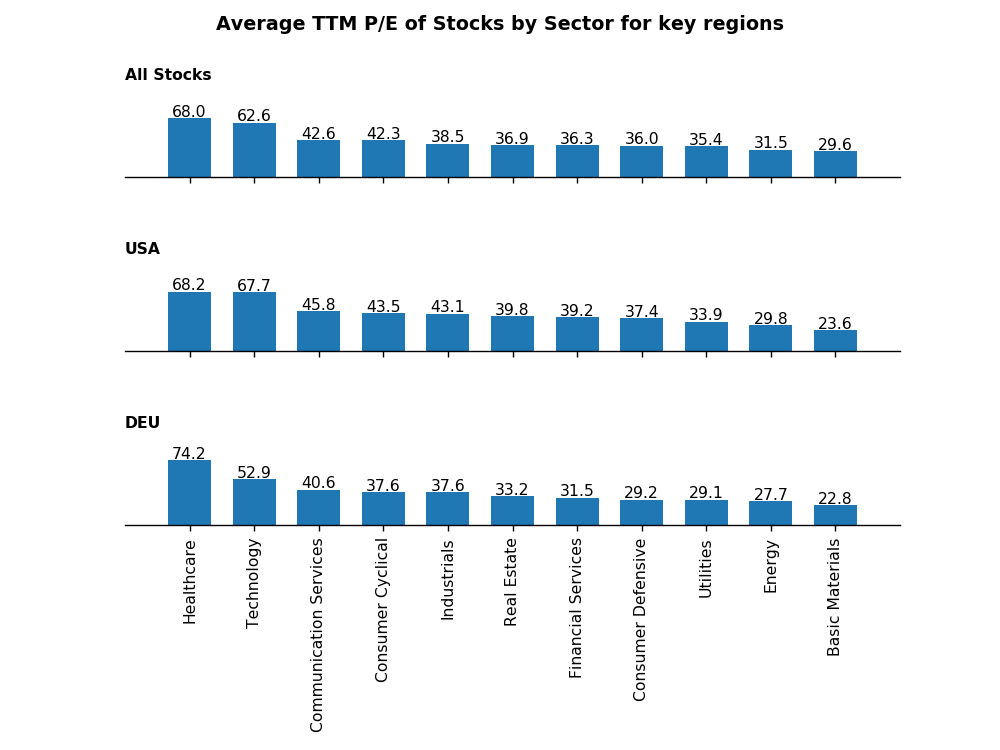

In [160]:
fig_pe, (ax_pe, ax_pe_usa, ax_pe_deu) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 6))

# All Stocks
pe = df_val_mean['PE_TTM']
x = [x*3 for x in range(len(pe))]
y = pe
bars = ax_pe.bar(x, y, width=2)
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1.5, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)
ax_pe.set_title('All Stocks', loc='left', fontsize=9, fontweight='bold')

# USA
pe_usa = df_val_mean_USA['PE_TTM']
x = [x*3 for x in range(len(pe_usa))]
y = pe_usa
bars = ax_pe_usa.bar(x, y, width=2)
for bar in bars:
    ax_pe_usa.text(bar.get_x()+1, bar.get_height()+1.5, '{:.1f}'.format(bar.get_height()), 
                   color='black', ha='center', fontsize=9)
ax_pe_usa.get_children()[22].set_color(None)
ax_pe_usa.get_children()[23].set_color(None)
ax_pe_usa.get_children()[25].set_color(None)
ax_pe_usa.set_title('USA', loc='left', fontsize=9, fontweight='bold')

# DEU
pe_deu = df_val_mean_DEU['PE_TTM']
x = [x*3 for x in range(len(pe_deu))]
y = pe_deu
bars = ax_pe_deu.bar(x, y, width=2)
for bar in bars:
    ax_pe_deu.text(bar.get_x()+1, bar.get_height()+1.5, '{:.1f}'.format(bar.get_height()), 
                   color='black', ha='center', fontsize=9)
ax_pe_deu.get_children()[22].set_color(None)
ax_pe_deu.get_children()[23].set_color(None)
ax_pe_deu.get_children()[25].set_color(None)
ax_pe_deu.set_title('DEU', loc='left', fontsize=9, fontweight='bold')

# Plot adjustments
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
plt.axis([-3, len(x)*3, 0, 100])
plt.suptitle('Average TTM P/E of Stocks by Sector for key regions', fontsize=11, fontweight='bold')
plt.yticks([])
plt.subplots_adjust(bottom=0.3, hspace=1)

for tick in ax_pe_deu.xaxis.get_ticklabels():
    tick.set_rotation(90)

[return to the top](#top)
#### P/E by Sector for past 10 yrs for US Stocks

<IPython.core.display.Javascript object>


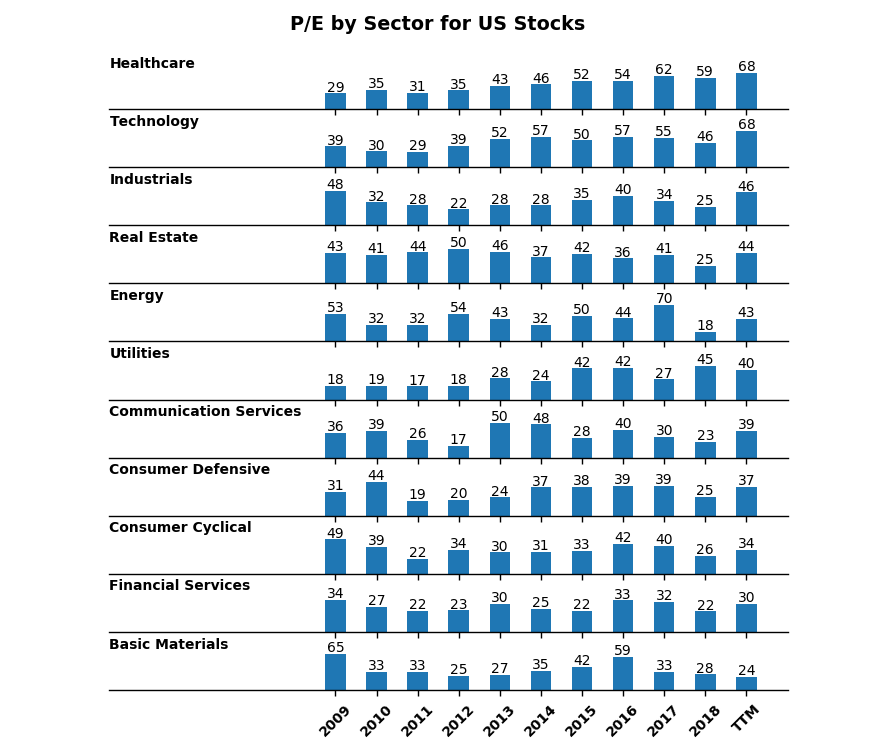

In [357]:
cols = list(filter(lambda col: col.startswith('PE_'), df.columns))[1:]

fig, axs = plt.subplots(11, 1, figsize=(7, 6), sharex=True)
sectors = df_val_mean_USA.index.values
x = list(range(11))

for sector, ax in zip(sectors, axs):
    y = df_val_mean_USA[cols].loc[sector].values
    p0 = ax.bar(x, y, width=0.5)
    #ax.set_title(sector, loc='left', fontsize=9, fontweight='bold')
    ax.spines['left'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    for pt in list(zip(x, y)):
        if pt[1] > 0:
            ax.text(pt[0], pt[1] + max(y)*0.05, '{:.0f}'.format(pt[1]), ha='center', fontsize=8)
    ax.set_yticks([])
    ax.axis([-5.5, 11, 0, max(y)+10])
    ax.set_xlim(-5.5, 11)
    ax.text(-5.5, max(y)+10, sector, fontweight='bold', fontsize=8)
    ax0 = ax
    
plt.suptitle('P/E by Sector for US Stocks', fontweight='bold', fontsize=11)
plt.subplots_adjust(top=0.91, bottom=0.08, hspace=0.4)
_ = plt.xticks(ticks=x, labels=list(map(lambda col: col[3:], cols)), fontsize=8, fontweight='bold')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

[return to the top](#top)
#### P/S by Sector for past 10 yrs for US Stocks

<IPython.core.display.Javascript object>


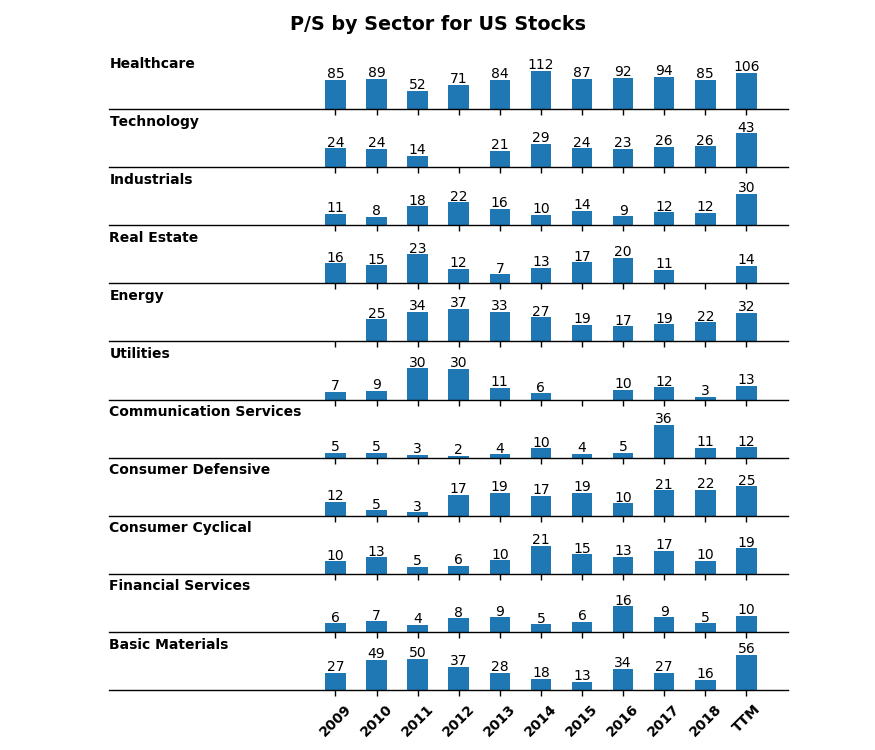

In [358]:
cols = list(filter(lambda col: col.startswith('PS_'), df.columns))

fig, axs = plt.subplots(11, 1, figsize=(7, 6), sharex=True)
sectors = df_val_mean_USA.index.values
x = list(range(11))

for sector, ax in zip(sectors, axs):
    y = df_val_mean_USA[cols].loc[sector].values
    p0 = ax.bar(x, y, width=0.5)
    #ax.set_title(sector, loc='left', fontsize=9, fontweight='bold')
    ax.spines['left'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    for pt in list(zip(x, y)):
        if pt[1] > 0:
            ax.text(pt[0], pt[1] + max(y)*0.05, '{:.0f}'.format(pt[1]), ha='center', fontsize=8)
    ax.set_yticks([])
    ax.axis([-5.5, 11, 0, max(y)+10])
    ax.set_xlim(-5.5, 11)
    ax.text(-5.5, max(y)+10, sector, fontweight='bold', fontsize=8)
    ax0 = ax
    
plt.suptitle('P/S by Sector for US Stocks', fontweight='bold', fontsize=11)
plt.subplots_adjust(top=0.91, bottom=0.08, hspace=0.4)
_ = plt.xticks(ticks=x, labels=list(map(lambda col: col[3:], cols)), fontsize=8, fontweight='bold')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

[return to the top](#top)
#### P/B by Sector for past 10 yrs for US Stocks

<IPython.core.display.Javascript object>


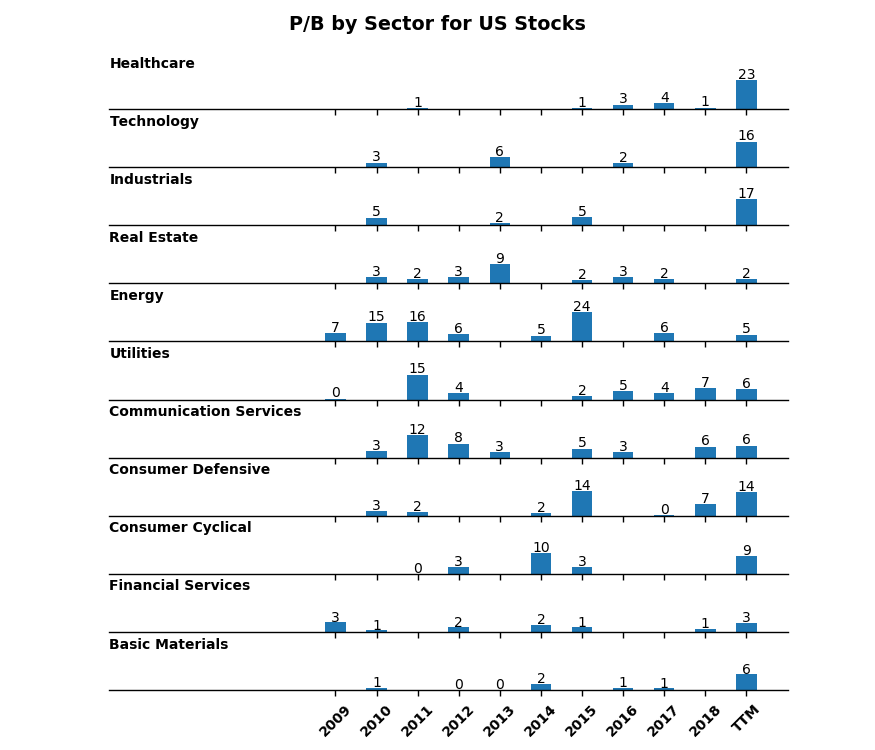

In [359]:
cols = list(filter(lambda col: col.startswith('PB_'), df.columns))

fig, axs = plt.subplots(11, 1, figsize=(7, 6), sharex=True)
sectors = df_val_mean_USA.index.values
x = list(range(11))

for sector, ax in zip(sectors, axs):
    y = df_val_mean_USA[cols].loc[sector].values
    p0 = ax.bar(x, y, width=0.5)
    #ax.set_title(sector, loc='left', fontsize=9, fontweight='bold')
    ax.spines['left'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    for pt in list(zip(x, y)):
        if pt[1] > 0:
            ax.text(pt[0], pt[1] + max(y)*0.05, '{:.0f}'.format(pt[1]), ha='center', fontsize=8)
    ax.set_yticks([])
    ax.axis([-5.5, 11, 0, max(y)+10])
    ax.set_xlim(-5.5, 11)
    ax.text(-5.5, max(y)+10, sector, fontweight='bold', fontsize=8)
    ax0 = ax
    
plt.suptitle('P/B by Sector for US Stocks', fontweight='bold', fontsize=11)
plt.subplots_adjust(top=0.91, bottom=0.08, hspace=0.4)
_ = plt.xticks(ticks=x, labels=list(map(lambda col: col[3:], cols)), fontsize=8, fontweight='bold')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

[return to the top](#top)
#### P/CF by Sector for past 10 yrs for US Stocks

<IPython.core.display.Javascript object>


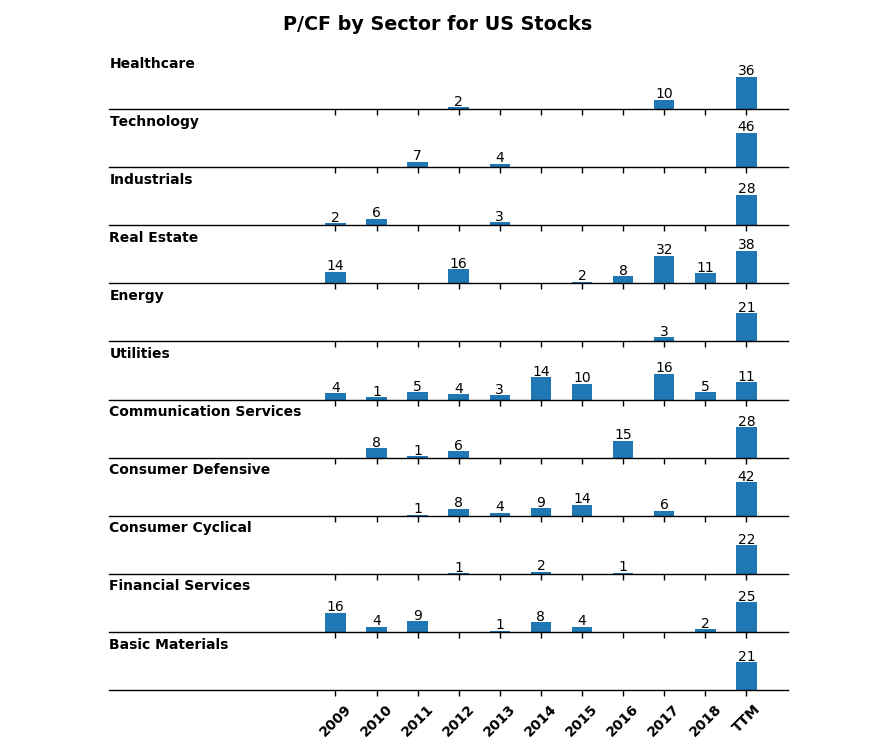

In [360]:
cols = list(filter(lambda col: col.startswith('PC_'), df.columns))

fig, axs = plt.subplots(11, 1, figsize=(7, 6), sharex=True)
sectors = df_val_mean_USA.index.values
x = list(range(11))

for sector, ax in zip(sectors, axs):
    y = df_val_mean_USA[cols].loc[sector].values
    p0 = ax.bar(x, y, width=0.5)
    #ax.set_title(sector, loc='left', fontsize=9, fontweight='bold')
    ax.spines['left'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['top'].set_color(None)
    for pt in list(zip(x, y)):
        if pt[1] > 0:
            ax.text(pt[0], pt[1] + max(y)*0.05, '{:.0f}'.format(pt[1]), ha='center', fontsize=8)
    ax.set_yticks([])
    ax.axis([-5.5, 11, 0, max(y)+10])
    ax.set_xlim(-5.5, 11)
    ax.text(-5.5, max(y)+10, sector, fontweight='bold', fontsize=8)
    ax0 = ax
    
plt.suptitle('P/CF by Sector for US Stocks', fontweight='bold', fontsize=11)
plt.subplots_adjust(top=0.91, bottom=0.08, hspace=0.4)
_ = plt.xticks(ticks=x, labels=list(map(lambda col: col[3:], cols)), fontsize=8, fontweight='bold')
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(45)

[return to the top](#top)
### Stocks in the Cannabis Industry
Using stocks listed on [marijuanaindex.com](http://marijuanaindex.com/stock-quotes/north-american-marijuana-index/) under North America

In [73]:
import json

with open('input/pot_stocks.json') as file:
    pot_symbols = json.loads(file.read())
    
pot_stocks = (pd.DataFrame(pot_symbols, columns=['ticker', 'country_c3'])
               .merge(df_master, how='left', on=['ticker', 'country_c3']).drop('country', axis=1)
               .rename(columns={'country_c3':'country', 'exchange_sym':'exch'}))

pot_stocks = (pot_stocks.where(((pot_stocks['country'] == 'USA') | 
                                (pot_stocks['country'] == 'CAN')) &
                               (pot_stocks['sector'] != '—'))
              .dropna(axis=0, how='all').sort_values(by='company'))

In [74]:
msg = 'Below are the {} stocks listed on marijuanaindex.com for North America.'
print(msg.format(len(pot_stocks['company'].unique())))

pot_stocks[['country', 'ticker', 'exch', 'company', 'sector', 'industry']]

Below are the 46 stocks listed on marijuanaindex.com for North America.


,country,ticker,exch,company,sector,industry
29,CAN,TGIF,XCNQ,1933 Industries Inc,Healthcare,Drug Manufacturers - Specialty & Generic
1,USA,ACRGF,PINX,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
2,CAN,ACRG.U,XCNQ,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
37,USA,APHA,XNYS,Aphria Inc,Healthcare,Drug Manufacturers - Specialty & Generic
0,CAN,ACB,XTSE,Aurora Cannabis Inc,Healthcare,Drug Manufacturers - Specialty & Generic
36,CAN,XLY,XTSX,Auxly Cannabis Group Inc,Healthcare,Drug Manufacturers - Specialty & Generic
40,USA,CVSI,PINX,CV Sciences Inc,Healthcare,Drug Manufacturers - Specialty & Generic
32,CAN,TRST,XTSE,CannTrust Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
4,CAN,CNNX,XCNQ,Cannex Capital Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
38,USA,CGC,XNYS,Canopy Growth Corp,Healthcare,Drug Manufacturers - Specialty & Generic


<a id="value"></a>
[return to the top](#top)

## Applying various criteria to filter common stocks

Below is a list of different rules that can be applied to the data to screen stocks (development of *italicized rules* is still in progress)

- **[Rule 0](#rule99): CAGR > 7% for past 7 years**
- **[Rule 1](#rule1): No earnings deficit (loss) for past 5 or 7 years**
- **[Rule 2](#rule2): Uniterrupted and increasing Dividends for past 5 yrs**
- **[Rule 3](#rule3): P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM**
- *[Rule 4](#rule4): Operating Cash Flow growth for the past 7 yr*
- *[Rule x](#rulex): P/B Ratio of 1.2 or less for TTM*
- *[Rule x](#rulex): Stocks with continuous revenue growth for the past 5 or 7 years*
- *[Rule x](#rulex): Filter for "bargain issues"*
- *[Rule x](#rulex): Owner earnings growth rate > 6% over past 7 years*
- *[Rule x](#rulex): Long-term debt < 50% of total capital*
- *[Rule x](#rulex): NAV per share > Stock Price*
- *[Rule x](#rulex): Growth Stocks as described by Benjamin Graham in _The Intelligent Investor_*
- *[Rule x](#rulex): Positive ratio of earnings to fixed charge*
- *[Rule x](#rulex): CAN SLIM*
- *[Rule x](#rulex):*
- *[Rule x](#rulex):*

*[Merge DataFrames](#mergerules) created for different rules to screen stocks.*

[return to the top](#top)
<a id="rule99"></a>
### Rule 0. CAGR > 7% for past 7 years

In [33]:
df_labels_keyratios

i0                      Revenue
i1                 Gross_Margin
i2             Operating_Income
i3             Operating_Margin
i4                   Net_Income
i5           Earnings_Per_Share
i6                    Dividends
i91                Payout_Ratio
i7                       Shares
i8         Book_Value_Per_Share
i9          Operating_Cash_Flow
i10                Cap_Spending
i11              Free_Cash_Flow
i90    Free_Cash_Flow_Per_Share
i80             Working_Capital
Name: 0, dtype: object

#### Revenue:

In [85]:
iid = 'i0'
field = 'Rev'
label = 'CAGR_{}_7yr'.format(field)

cols = [col for col in df_keyratios.columns if iid in col or col.startswith('Y')]

df_rule0_Rev = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))
df_rule0_Rev[label] = 100 * ((df_rule0_Rev['{}_Y9'.format(iid)] / df_rule0_Rev['{}_Y2'.format(iid)])**(1/7) - 1)

df_rule0_Rev = (df_rule0_Rev.where(df_rule0_Rev[label] > 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_Rev)))

Total of 6,036 records meet this criterium.


#### Operating Income:

In [86]:
iid = 'i2'
field = 'OpeInc'
label = 'CAGR_{}_7yr'.format(field)

cols = [col for col in df_keyratios.columns if iid in col or col.startswith('Y')]

df_rule0_OpeInc = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))
df_rule0_OpeInc[label] = 100 * (
    (df_rule0_OpeInc['{}_Y9'.format(iid)] / df_rule0_OpeInc['{}_Y2'.format(iid)])**(1/7) - 1)

df_rule0_OpeInc = (df_rule0_OpeInc.where(df_rule0_OpeInc[label] > 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_OpeInc)))

Total of 10,048 records meet this criterium.


#### Free Cash Flow

In [87]:
iid = 'i11'
field = 'FreeCF'
label = 'CAGR_{}_7yr'.format(field)

cols = [col for col in df_keyratios.columns if iid in col or col.startswith('Y')]

df_rule0_FreeCF = (df_keyratios.where(df_keyratios['Y9'] > pd.to_datetime('2018-02-01')).dropna(axis=0, how='all'))
df_rule0_FreeCF[label] = 100 * ((df_rule0_FreeCF['{}_Y9'.format(iid)] / df_rule0_FreeCF['{}_Y2'.format(iid)])**(1/7) - 1)

df_rule0_FreeCF = (df_rule0_FreeCF.where(df_rule0_FreeCF[label] > 7).dropna(axis=0, how='all')
                .sort_values(by=label, ascending=False))

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule0_FreeCF)))

Total of 10,333 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule1"></a>
### Rule 1. No earnings deficit (loss) for past 5 or 7 years
Criteria: *"Find companies with positive earnings per share growth during the past five years with no earnings deficits. Earnings need to be higher in the most recent year than five years ago. Avoiding companies with earnings deficits during the past five years will help you stay clear of high-risk companies."* [(Source)](https://cabotwealth.com/daily/value-investing/benjamin-grahams-value-stock-criteria/)

#### 5 Years:
*a. Identify Net Income column labels in* `df_annualIS`

In [37]:
ilabel = 'Net income'
df_labels = df_labels_aIS[df_labels_aIS['value'] == ilabel].sort_values(by='value')
df_labels

,value
header,
label_i50,Net income
label_i70,Net income
label_i80,Net income


*b. Get column headers for 'Net income' values for the past 5 yrs*

In [38]:
i_ids = [(label[-3:] + '_') for label in df_labels.index]

def get_icols(col):
    for i_id in i_ids:
        if i_id in col:
            return True
    return False

main_cols = ['ticker_id', 'exchange_id', 
             'country', 'exchange_sym', 'ticker', 'company', 
             'sector', 'industry', 'stock_type', 'style', 
             'Year_Y_6', 'Year_Y_5', 'Year_Y_4', 'Year_Y_3', 'Year_Y_2', 'Year_Y_1']
data_cols = sorted(list(filter(get_icols, df_annualIS.columns)), key=lambda r: (r[-1], r[5:8]), reverse=True)
print('The following columns contain \'{}\' values:\n{}'.format(ilabel, data_cols))

The following columns contain 'Net income' values:
['data_i80_Y_6', 'data_i70_Y_6', 'data_i50_Y_6', 'data_i80_Y_5', 'data_i70_Y_5', 'data_i50_Y_5', 'data_i80_Y_4', 'data_i70_Y_4', 'data_i50_Y_4', 'data_i80_Y_3', 'data_i70_Y_3', 'data_i50_Y_3', 'data_i80_Y_2', 'data_i70_Y_2', 'data_i50_Y_2', 'data_i80_Y_1', 'data_i70_Y_1', 'data_i50_Y_1']


*c. Create 'Net Income' DataFrame*

In [39]:
df_netinc5 = (df_annualIS
              .where((df_annualIS['security_type'] == 'Stock') & 
                     (df_annualIS['Year_Y_5'] > pd.to_datetime('2018-01')))
              .dropna(axis=0, how='all')
              .drop(['country'], axis=1)
              .rename(columns={'country_c3':'country'})
             )[main_cols + data_cols]

np_netinc = df_netinc5[data_cols].values
netinc_cols = [('NetIncome_Y' + data_cols[i * 3][-1], (i * 3, i * 3 + 1, i * 3 + 2))
               for i in range(int(len(data_cols)/3))]

vals = []
for row in np_netinc:
    row_vals = []
    for i in range(len(netinc_cols)):
        val = None
        for col in netinc_cols[i][1]:
            if not np.isnan(row[col]):
                val = row[col]
                break
        row_vals.append(val)
    vals.append(row_vals)
    
df_netinc_vals = pd.DataFrame(vals, columns=list(zip(*netinc_cols))[0])
df_netinc5 = df_netinc5[main_cols].join(df_netinc_vals)

In [42]:
df_rule1_5 = df_netinc5.where((df_netinc5['NetIncome_Y6'] > 0) & 
                            ((df_netinc5['NetIncome_Y5'] > 0) | (df_netinc5['NetIncome_Y5'].isna() & df_netinc5['NetIncome_Y4'].isna() & df_netinc5['NetIncome_Y3'].isna() & df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
                            ((df_netinc5['NetIncome_Y4'] > 0) | (df_netinc5['NetIncome_Y4'].isna() & df_netinc5['NetIncome_Y3'].isna() & df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
                            ((df_netinc5['NetIncome_Y3'] > 0) | (df_netinc5['NetIncome_Y3'].isna() & df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
                            ((df_netinc5['NetIncome_Y2'] > 0) | (df_netinc5['NetIncome_Y2'].isna() & df_netinc5['NetIncome_Y1'].isna())) & 
                            ((df_netinc5['NetIncome_Y1'] > 0) | (df_netinc5['NetIncome_Y1'].isna()))
                           ).dropna(axis=0, how='all')

df_rule1_5 = df_rule1_5[['ticker_id', 'exchange_id'] + df_rule1_5.columns.values.tolist()[-12:]]
df_rule1_5.columns = [re.sub('Year_Y_', 'r1_Y', col) for col in df_rule1_5.columns]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule1_5)))

Total of 18,107 records meet this criterium.


#### 7 Years:

In [44]:
cols = ['ticker_id', 'exchange_id'] + \
        [col for col in df_keyratios.columns if col.startswith('i4_') or col.startswith('Y')]

df_rule1_7 = (df_keyratios
              .where((df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                     (df_keyratios['i4_Y10'] > 0) & 
                     ((df_keyratios['i4_Y9'] > 0) | (df_keyratios['i4_Y9'].isna() & df_keyratios['i4_Y8'].isna() & df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y8'] > 0) | (df_keyratios['i4_Y8'].isna() & df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y7'] > 0) | (df_keyratios['i4_Y7'].isna() & df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y6'] > 0) | (df_keyratios['i4_Y6'].isna() & df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y5'] > 0) | (df_keyratios['i4_Y5'].isna() & df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y4'] > 0) | (df_keyratios['i4_Y4'].isna() & df_keyratios['i4_Y3'].isna())) & 
                     ((df_keyratios['i4_Y3'] > 0) | (df_keyratios['i4_Y3'].isna())))
              .dropna(axis=0, how='all'))[cols]

df_rule1_7.columns = [re.sub('i4_', 'NetIncome_r1_', col) for col in df_rule1_7.columns]
df_rule1_7.columns = [re.sub('^Y', 'r1_Y', col) for col in df_rule1_7.columns]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule1_7)))

Total of 14,574 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule2"></a>
### Rule 2. Uniterrupted and increasing *Dividends* for past 7 yrs

**a. Identify *Dividends* column label in** `df_keyratios`

In [45]:
icol = df_labels_keyratios[df_labels_keyratios == 'Dividends'].index[0]
icol

'i6'

**b. Get column headers for *Dividends* for the past 5 yrs**

In [46]:
main_cols = ['ticker_id', 'exchange_id', 
             #'country_c3', 'exchange_sym', 'ticker', 'company', 
             #'sector', 'industry', 'stock_type', 'style', 
             'Y10', 'Y9', 'Y8', 'Y7', 'Y6', 'Y5']
icols = sorted([col for col in df_keyratios.columns if icol + '_' in col], 
               key=lambda col: int(col[4:]), reverse=True)[:8]
icols

['i6_Y10', 'i6_Y9', 'i6_Y8', 'i6_Y7', 'i6_Y6', 'i6_Y5', 'i6_Y4', 'i6_Y3']

**c. Create 'Net Income' DataFrame**

In [54]:
df_rule2 = (df_keyratios
            .where((df_keyratios['Y9'] > pd.to_datetime('2018-01')) & 
                   (df_keyratios['i6_Y10'] >= df_keyratios['i6_Y9']) &
                   ((df_keyratios['i6_Y9'] >= df_keyratios['i6_Y8']) | (df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna() & df_keyratios['i6_Y6'].isna() & df_keyratios['i6_Y7'].isna() & df_keyratios['i6_Y8'].isna())) & 
                   ((df_keyratios['i6_Y8'] >= df_keyratios['i6_Y7']) | (df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna() & df_keyratios['i6_Y6'].isna() & df_keyratios['i6_Y7'].isna())) & 
                   ((df_keyratios['i6_Y7'] >= df_keyratios['i6_Y6']) | (df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna() & df_keyratios['i6_Y6'].isna())) &
                   ((df_keyratios['i6_Y6'] >= df_keyratios['i6_Y5']) | (df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna() & df_keyratios['i6_Y5'].isna())) &
                   ((df_keyratios['i6_Y5'] >= df_keyratios['i6_Y4']) | (df_keyratios['i6_Y3'].isna() & df_keyratios['i6_Y4'].isna())) &
                   ((df_keyratios['i6_Y4'] >= df_keyratios['i6_Y3']) | (df_keyratios['i6_Y3'].isna())))
            .dropna(axis=0, how='all').sort_values(by='Y9', ascending=False))[main_cols + icols]

df_rule2.columns = main_cols + [col.replace('i6', 'Dividend') for col in icols]
df_rule2.columns = [re.sub('^Y', 'r2_Y', col) for col in df_rule2.columns]

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule2)))

Total of 11,314 records meet this criterium.


[return to top of this section](#value),
[return to the top](#top)
<a id="rule3"></a>
### Rule 3. P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM

In [72]:
pe_cols = [col for col in df_vals.columns if 'PE_' in col]
pe_cols = ['ticker_id', 'exchange_id'] + [pe_cols[len(pe_cols)-i-1] for i in range(len(pe_cols))][:8]
pe_cols

['ticker_id',
 'exchange_id',
 'PE_TTM',
 'PE_2018',
 'PE_2017',
 'PE_2016',
 'PE_2015',
 'PE_2014',
 'PE_2013',
 'PE_2012']

In [73]:
df_rule3 = (df_vals[pe_cols]
            .where((df_vals['PE_TTM'] <= 20) &
                   (df_vals['PE_2018'] <= 25) &
                   ((df_vals['PE_2017'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna() & df_vals['PE_2015'].isna() & df_vals['PE_2016'].isna() & df_vals['PE_2017'].isna())) &
                   ((df_vals['PE_2016'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna() & df_vals['PE_2015'].isna() & df_vals['PE_2016'].isna())) &
                   ((df_vals['PE_2015'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna() & df_vals['PE_2015'].isna())) &
                   ((df_vals['PE_2014'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna() & df_vals['PE_2014'].isna())) &
                   ((df_vals['PE_2013'] <= 25) | (df_vals['PE_2012'].isna() & df_vals['PE_2013'].isna())) & 
                   ((df_vals['PE_2012'] <= 25) | (df_vals['PE_2012'].isna())))
            .dropna(axis=0, how='all').sort_values(by='PE_TTM'))

print('Total of {:,.0f} records meet this criterium.'.format(len(df_rule3)))

Total of 10,944 records meet this criterium.


In [74]:
df_rule3

,ticker_id,exchange_id,PE_TTM,PE_2018,PE_2017,PE_2016,PE_2015,PE_2014,PE_2013,PE_2012
62167,622811.0,16.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
36443,115381.0,144.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
60699,606643.0,16.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
38564,132801.0,16.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
60700,606643.0,142.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
60701,606643.0,144.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
62171,622811.0,144.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
38565,132801.0,144.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
62172,622811.0,145.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
38608,133237.0,16.0,0.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN


[return to top of this section](#value),
[return to the top](#top)
<a id="rule4"></a>
### Rule 4. Operating Cash Flow growth for the past 5 or 7 years
#### 5 Years:
a. Identify *Operating Cash Flow* column labels in `df_annualCF`

In [32]:
ilabel = 'Operating'
df_labels = df_labels_aCF[df_labels_aCF['value'].str.contains(ilabel)].sort_values(by='value')
df_labels

,value
header,
label_i100,Operating cash flow


*b. Get column headers for 'Revenue' values for the past 5 yrs*

In [52]:
main_cols = ['ticker_id', 'exchange_id', 'Year_Y_6', 'Year_Y_5', 'Year_Y_4', 'Year_Y_3', 'Year_Y_2', 'Year_Y_1']

data_cols = [col for col in df_annualCF.columns if 'i100_' in col]

print('The following columns contain \'{}\' values:\n{}'.format(ilabel, data_cols))

The following columns contain 'Net income' values:
['data_i100_Y_1', 'data_i100_Y_2', 'data_i100_Y_3', 'data_i100_Y_4', 'data_i100_Y_5', 'data_i100_Y_6']


*c. Create 'Revenue' DataFrame*

In [53]:
df_rule4_5 = (df_annualCF
              .where((df_annualCF['security_type'] == 'Stock') & 
                     (df_annualCF['Year_Y_5'] > pd.to_datetime('2018-01')) & 
                     (df_annualCF[data_cols[5]] > 0) & 
                     ((df_annualCF[data_cols[4]] > df_annualCF[data_cols[3]]) | (df_annualCF[data_cols[0]].isna() & df_annualCF[data_cols[1]].isna() & df_annualCF[data_cols[2]].isna() & df_annualCF[data_cols[3]].isna())) & 
                     ((df_annualCF[data_cols[3]] > df_annualCF[data_cols[2]]) | (df_annualCF[data_cols[0]].isna() & df_annualCF[data_cols[1]].isna() & df_annualCF[data_cols[2]].isna())) & 
                     ((df_annualCF[data_cols[2]] > df_annualCF[data_cols[1]]) | (df_annualCF[data_cols[0]].isna() & df_annualCF[data_cols[1]].isna())) & 
                     ((df_annualCF[data_cols[1]] > df_annualCF[data_cols[0]]) | (df_annualCF[data_cols[0]].isna()))
                    )
              .dropna(axis=0, how='all')
              .drop(['country'], axis=1)
              .rename(columns={'country_c3':'country'})
             )[main_cols + data_cols]

df_rule4_5.columns = [re.sub('Year_Y_', 'r6_Y', col) for col in df_rule4_5.columns]
df_rule4_5.columns = [re.sub('data_i100_Y_', 'OpeCF_r6_Y', col) for col in df_rule4_5.columns]

In [54]:
df_rule4_5

,ticker_id,exchange_id,r6_Y6,r6_Y5,r6_Y4,r6_Y3,r6_Y2,r6_Y1,OpeCF_r6_Y1,OpeCF_r6_Y2,OpeCF_r6_Y3,OpeCF_r6_Y4,OpeCF_r6_Y5,OpeCF_r6_Y6
3,18686.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,3.343250e+08,3.426110e+08,3.925010e+08,4.503250e+08,5.703390e+08,5.703390e+08
7,19849.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,2.467150e+08,2.714270e+08,3.394490e+08,4.026970e+08,4.329820e+08,4.329820e+08
8,19335.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,3.841260e+08,4.637210e+08,4.840390e+08,6.585130e+08,7.342920e+08,7.342920e+08
10,19021.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.174010e+08,1.313850e+08,1.388640e+08,1.550140e+08,1.647310e+08,1.647310e+08
11,19575.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.460680e+08,1.862100e+08,2.255500e+08,2.485800e+08,2.622980e+08,2.622980e+08
14,19322.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.504430e+08,2.069960e+08,2.646830e+08,3.631010e+08,4.490880e+08,4.490880e+08
15,20144.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.684990e+08,1.910950e+08,2.036950e+08,3.075430e+08,3.373960e+08,3.373960e+08
20,20145.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2016-12-01,2.575240e+08,4.634760e+08,5.379040e+08,6.505500e+08,1.187239e+09,1.187239e+09
22,20219.0,302.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.424000e+08,2.298000e+08,4.920000e+08,7.240000e+08,8.920000e+08,8.920000e+08
25,4489405.0,552.0,TTM,2018-12-01,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.081060e+08,1.858970e+08,2.463040e+08,3.094250e+08,3.916780e+08,3.916780e+08


#### 7 Years:

In [55]:
cols = ['ticker_id', 'exchange_id'] + \
        [col for col in df_keyratios.columns if col.startswith('i9_') or col.startswith('Y')]

df_rule4_7 = (df_keyratios
              .where((df_keyratios['security_type'] == 'Stock') & 
                     (df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                     (df_keyratios['i9_Y10'] > 0) & 
                     ((df_keyratios['i9_Y9'] > df_keyratios['i9_Y8']) | (df_keyratios['i9_Y9'].isna() & df_keyratios['i9_Y8'].isna() & df_keyratios['i9_Y7'].isna() & df_keyratios['i9_Y6'].isna() & df_keyratios['i9_Y5'].isna() & df_keyratios['i9_Y4'].isna() & df_keyratios['i9_Y3'].isna())) & 
                     ((df_keyratios['i9_Y8'] > df_keyratios['i9_Y7']) | (df_keyratios['i9_Y8'].isna() & df_keyratios['i9_Y7'].isna() & df_keyratios['i9_Y6'].isna() & df_keyratios['i9_Y5'].isna() & df_keyratios['i9_Y4'].isna() & df_keyratios['i9_Y3'].isna())) & 
                     ((df_keyratios['i9_Y7'] > df_keyratios['i9_Y6']) | (df_keyratios['i9_Y7'].isna() & df_keyratios['i9_Y6'].isna() & df_keyratios['i9_Y5'].isna() & df_keyratios['i9_Y4'].isna() & df_keyratios['i9_Y3'].isna())) & 
                     ((df_keyratios['i9_Y6'] > df_keyratios['i9_Y5']) | (df_keyratios['i9_Y6'].isna() & df_keyratios['i9_Y5'].isna() & df_keyratios['i9_Y4'].isna() & df_keyratios['i9_Y3'].isna())) & 
                     ((df_keyratios['i9_Y5'] > df_keyratios['i9_Y4']) | (df_keyratios['i9_Y5'].isna() & df_keyratios['i9_Y4'].isna() & df_keyratios['i9_Y3'].isna())) & 
                     ((df_keyratios['i9_Y4'] > df_keyratios['i9_Y3']) | (df_keyratios['i9_Y4'].isna() & df_keyratios['i9_Y3'].isna()))
                    )
              .dropna(axis=0, how='all'))[cols]

df_rule4_7.columns = [re.sub('i9_', 'OpeCF_r0_', col) for col in df_rule4_7.columns]
df_rule4_7.columns = [re.sub('^Y', 'r6_Y', col) for col in df_rule4_7.columns]

In [56]:
df_rule4_7

,ticker_id,exchange_id,OpeCF_r0_Y0,OpeCF_r0_Y1,OpeCF_r0_Y2,OpeCF_r0_Y3,OpeCF_r0_Y4,OpeCF_r0_Y5,OpeCF_r0_Y6,OpeCF_r0_Y7,...,r6_Y1,r6_Y2,r6_Y3,r6_Y4,r6_Y5,r6_Y6,r6_Y7,r6_Y8,r6_Y9,r6_Y10
3,18686.0,302.0,206.0,219.0,247.0,306.0,313.0,334.0,343.0,393.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
7,19849.0,302.0,180.0,189.0,208.0,210.0,244.0,247.0,271.0,339.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
8,19335.0,302.0,137.0,134.0,172.0,211.0,265.0,384.0,464.0,484.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
10,19021.0,302.0,81.0,77.0,87.0,92.0,110.0,117.0,131.0,139.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
11,19575.0,302.0,59.0,74.0,80.0,99.0,121.0,146.0,186.0,226.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
14,19322.0,302.0,63.0,61.0,79.0,105.0,141.0,150.0,207.0,265.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
15,20144.0,302.0,21.0,59.0,112.0,117.0,148.0,168.0,191.0,204.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
25,4489405.0,552.0,NaN,NaN,NaN,22.0,55.0,108.0,186.0,246.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
26,3216204.0,552.0,257.0,257.0,245.0,297.0,314.0,346.0,360.0,419.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
27,2292121.0,552.0,81.0,105.0,144.0,216.0,271.0,338.0,367.0,539.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule X. Stocks with continuous revenue growth for the past 5 or 7 years
#### 5 Years:
a. Identify *Revenue* column labels in `df_annualIS`

In [89]:
ilabel = 'Revenue'
df_labels = df_labels_aIS[df_labels_aIS['value'] == ilabel].sort_values(by='value')
df_labels

,value
header,
label_i1,Revenue
label_s1,Revenue


*b. Get column headers for 'Revenue' values for the past 5 yrs*

In [90]:
main_cols = ['ticker_id', 'exchange_id', 
             'country', 'exchange_sym', 'ticker', 'company', 'lastprice', 'yield', 
             'sector', 'industry', 'stock_type', 'style', 
             'Year_Y_6', 'Year_Y_5', 'Year_Y_4', 'Year_Y_3', 'Year_Y_2', 'Year_Y_1']

data_cols = [col for col in df_annualIS if 'i1_' in col]

print('The following columns contain \'{}\' values:\n{}'.format(ilabel, data_cols))

The following columns contain 'Revenue' values:
['data_i1_Y_1', 'data_i1_Y_2', 'data_i1_Y_3', 'data_i1_Y_4', 'data_i1_Y_5', 'data_i1_Y_6']


*c. Create 'Revenue' DataFrame*

In [91]:
df_rule0_5 = (df_annualIS
              .where((df_annualIS['security_type'] == 'Stock') & 
                     (df_annualIS['Year_Y_5'] > pd.to_datetime('2018-01')) & 
                     (df_annualIS[data_cols[5]] > 0) & 
                     ((df_annualIS[data_cols[4]] > df_annualIS[data_cols[3]]) | (df_annualIS[data_cols[0]].isna() & df_annualIS[data_cols[1]].isna() & df_annualIS[data_cols[2]].isna() & df_annualIS[data_cols[3]].isna())) & 
                     ((df_annualIS[data_cols[3]] > df_annualIS[data_cols[2]]) | (df_annualIS[data_cols[0]].isna() & df_annualIS[data_cols[1]].isna() & df_annualIS[data_cols[2]].isna())) & 
                     ((df_annualIS[data_cols[2]] > df_annualIS[data_cols[1]]) | (df_annualIS[data_cols[0]].isna() & df_annualIS[data_cols[1]].isna())) & 
                     ((df_annualIS[data_cols[1]] > df_annualIS[data_cols[0]]) | (df_annualIS[data_cols[0]].isna()))
                    )
              .dropna(axis=0, how='all')
              .drop(['country'], axis=1)
              .rename(columns={'country_c3':'country'})
             )[main_cols + data_cols]

df_rule0_5.columns = [re.sub('Year_Y_', 'r0_Y', col) for col in df_rule0_5.columns]
df_rule0_5.columns = [re.sub('data_i1_Y_', 'Rev_r0_Y', col) for col in df_rule0_5.columns]

In [92]:
df_rule0_5

,ticker_id,exchange_id,country,exchange_sym,ticker,company,lastprice,yield,sector,industry,...,r0_Y4,r0_Y3,r0_Y2,r0_Y1,Rev_r0_Y1,Rev_r0_Y2,Rev_r0_Y3,Rev_r0_Y4,Rev_r0_Y5,Rev_r0_Y6
0,1.0,374.0,USA,ARCX,OGCP,Empire State Realty OP LP Operating Partnershi...,15.07,2.79,Real Estate,REIT - Diversified,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,6.353260e+08,6.576340e+08,6.780000e+08,7.124680e+08,7.315110e+08,7.315110e+08
1,2.0,374.0,USA,ARCX,FISK,Empire State Realty OP LP Operating Partnershi...,15.77,2.66,Real Estate,REIT - Diversified,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,6.353260e+08,6.576340e+08,6.780000e+08,7.124680e+08,7.315110e+08,7.315110e+08
2,3.0,374.0,USA,ARCX,ESBA,Empire State Realty OP LP Operating Partnershi...,15.11,2.78,Real Estate,REIT - Diversified,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,6.353260e+08,6.576340e+08,6.780000e+08,7.124680e+08,7.315110e+08,7.315110e+08
3,16558.0,44.0,USA,XNAS,LAMR,Lamar Advertising Co Class A,80.28,4.61,Real Estate,REIT - Diversified,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.287060e+09,1.353396e+09,1.500294e+09,1.541260e+09,1.627222e+09,1.627222e+09
5,20371.0,302.0,USA,XNYS,STOR,STORE Capital Corp,32.14,4.04,Real Estate,REIT - Diversified,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.904410e+08,2.847620e+08,3.763430e+08,4.528470e+08,5.407560e+08,5.407560e+08
6,18686.0,302.0,USA,XNYS,ARE,Alexandria Real Estate Equities Inc,138.66,2.74,Real Estate,REIT - Office,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,7.203940e+08,8.195540e+08,8.978930e+08,1.124511e+09,1.327459e+09,1.327459e+09
10,20018.0,302.0,USA,XNYS,HPP,Hudson Pacific Properties Inc,34.36,2.91,Real Estate,REIT - Office,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,2.534150e+08,5.208500e+08,6.396390e+08,7.281390e+08,7.284180e+08,7.284180e+08
11,19849.0,302.0,USA,XNYS,DEI,Douglas Emmett Inc,40.75,2.50,Real Estate,REIT - Office,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,5.995390e+08,6.357740e+08,7.425510e+08,8.120520e+08,8.813160e+08,8.813160e+08
12,19240.0,302.0,USA,XNYS,KRC,Kilroy Realty Corp,75.34,2.42,Real Estate,REIT - Office,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,5.217250e+08,5.812750e+08,6.425720e+08,7.190010e+08,7.472980e+08,7.472980e+08
13,19108.0,302.0,USA,XNYS,RHP,Ryman Hospitality Properties Inc,81.32,4.24,Real Estate,REIT - Hotel & Motel,...,2017-12-01,2016-12-01,2015-12-01,2014-12-01,1.040991e+09,1.092124e+09,1.149207e+09,1.184719e+09,1.275118e+09,1.275118e+09


#### 7 Years:

In [93]:
cols = ['ticker_id', 'exchange_id', 'country_c3', 'exchange_sym', 'ticker', 'company', 
        'lastprice', 'yield', 'sector', 'industry'] + \
        [col for col in df_keyratios.columns if col.startswith('i0_') or col.startswith('Y')]

df_rule0_7 = (df_keyratios
              .where((df_keyratios['security_type'] == 'Stock') & 
                     (df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                     (df_keyratios['i0_Y10'] > 0) & 
                     ((df_keyratios['i0_Y9'] > df_keyratios['i0_Y8']) | (df_keyratios['i0_Y9'].isna() & df_keyratios['i0_Y8'].isna() & df_keyratios['i0_Y7'].isna() & df_keyratios['i0_Y6'].isna() & df_keyratios['i0_Y5'].isna() & df_keyratios['i0_Y4'].isna() & df_keyratios['i0_Y3'].isna())) & 
                     ((df_keyratios['i0_Y8'] > df_keyratios['i0_Y7']) | (df_keyratios['i0_Y8'].isna() & df_keyratios['i0_Y7'].isna() & df_keyratios['i0_Y6'].isna() & df_keyratios['i0_Y5'].isna() & df_keyratios['i0_Y4'].isna() & df_keyratios['i0_Y3'].isna())) & 
                     ((df_keyratios['i0_Y7'] > df_keyratios['i0_Y6']) | (df_keyratios['i0_Y7'].isna() & df_keyratios['i0_Y6'].isna() & df_keyratios['i0_Y5'].isna() & df_keyratios['i0_Y4'].isna() & df_keyratios['i0_Y3'].isna())) & 
                     ((df_keyratios['i0_Y6'] > df_keyratios['i0_Y5']) | (df_keyratios['i0_Y6'].isna() & df_keyratios['i0_Y5'].isna() & df_keyratios['i0_Y4'].isna() & df_keyratios['i0_Y3'].isna())) & 
                     ((df_keyratios['i0_Y5'] > df_keyratios['i0_Y4']) | (df_keyratios['i0_Y5'].isna() & df_keyratios['i0_Y4'].isna() & df_keyratios['i0_Y3'].isna())) & 
                     ((df_keyratios['i0_Y4'] > df_keyratios['i0_Y3']) | (df_keyratios['i0_Y4'].isna() & df_keyratios['i0_Y3'].isna()))
                    )
              .dropna(axis=0, how='all'))[cols]

df_rule0_7.columns = [re.sub('i0_', 'Rev_r0_', col) for col in df_rule0_7.columns]
df_rule0_7.columns = [re.sub('^Y', 'r0_Y', col) for col in df_rule0_7.columns]

In [94]:
df_rule0_7

,ticker_id,exchange_id,country_c3,exchange_sym,ticker,company,lastprice,yield,sector,industry,...,r0_Y1,r0_Y2,r0_Y3,r0_Y4,r0_Y5,r0_Y6,r0_Y7,r0_Y8,r0_Y9,r0_Y10
0,1.0,374.0,USA,ARCX,OGCP,Empire State Realty OP LP Operating Partnershi...,15.07,2.79,Real Estate,REIT - Diversified,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2.0,374.0,USA,ARCX,FISK,Empire State Realty OP LP Operating Partnershi...,15.77,2.66,Real Estate,REIT - Diversified,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3.0,374.0,USA,ARCX,ESBA,Empire State Realty OP LP Operating Partnershi...,15.11,2.78,Real Estate,REIT - Diversified,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
5,20371.0,302.0,USA,XNYS,STOR,STORE Capital Corp,32.14,4.04,Real Estate,REIT - Diversified,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
11,19849.0,302.0,USA,XNYS,DEI,Douglas Emmett Inc,40.75,2.50,Real Estate,REIT - Office,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
12,19240.0,302.0,USA,XNYS,KRC,Kilroy Realty Corp,75.34,2.42,Real Estate,REIT - Office,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
16,18925.0,302.0,USA,XNYS,NNN,National Retail Properties Inc,51.54,3.83,Real Estate,REIT - Retail,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
17,19047.0,302.0,USA,XNYS,EPR,EPR Properties,77.00,5.67,Real Estate,REIT - Retail,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
18,19071.0,302.0,USA,XNYS,FRT,Federal Realty Investment Trust,132.20,3.07,Real Estate,REIT - Retail,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
19,18700.0,302.0,USA,XNYS,ACC,American Campus Communities Inc,47.33,3.89,Real Estate,REIT - Residential,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. P/B Ratio of 1.2 or less for TTM

In [51]:
pb_cols = [col for col in df_vals.columns if 'PB_' in col]
pb_cols = [pb_cols[len(pb_cols)-i-1] for i in range(len(pb_cols))][:6]
pb_cols

['PB_TTM', 'PB_2018', 'PB_2017', 'PB_2016', 'PB_2015', 'PB_2014']

In [52]:
df_rule5 = (df_vals[['ticker_id', 'exchange_id'] + pb_cols]
            .where(df_vals['PB_TTM'] <= 1).dropna(axis=0))

In [53]:
df_rule5

,ticker_id,exchange_id,PB_TTM,PB_2018,PB_2017,PB_2016,PB_2015,PB_2014
144,139.0,1.0,0.7,0.6,0.7,0.2,0.6,0.8
148,143.0,1.0,0.1,0.1,0.3,0.6,0.2,0.5
308,302.0,1.0,0.9,1.0,3.6,-14.1,0.9,0.1
340,335.0,1.0,0.8,0.6,1.8,0.3,0.2,0.8
366,361.0,1.0,0.5,0.5,1.2,0.9,2.1,8.5
400,396.0,1.0,0.6,0.6,1.4,2.8,5.1,4.5
513,511.0,1.0,1.0,0.9,1.9,2.1,1.0,1.0
601,602.0,1.0,0.3,0.4,0.9,2.4,0.2,0.2
672,675.0,1.0,0.8,0.6,1.5,2.1,1.7,3.1
686,689.0,1.0,0.2,0.1,0.8,0.9,0.7,1.0


[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. Filtering for *bargain issues* as described by Benjamin Graham in *The Intelligent Investor*:

In his book, Graham defines bargain issues as common stocks where:

- $stock\ price\ < \frac{2}{3}\ net\ current\ asset\ value\ per\ share\ (NCAVPS)\$

- $net\ current\ asset\ value\ (NCAV)\ = current\ assets\ - total\ liabilities\ - preferred\ stocks\$

In [141]:
# df_master columns
cols1 = ['ticker_id', 'exchange_id', 'country_c3', 'exchange_sym', 'ticker', 'company',
       'industry', 'sector', 'security_type', 'lastprice']

# df_quarterlyBS columns
cols2 = ['ticker_id', 'exchange_id', 'Year_Y_5', 
         'label_i81', 'data_i81_Y_5', # Preferred stock
         #'label_g1', 'data_g1_Y_5', # Assets / Current assets
         'label_s1', 'data_s1_Y_5', # Assets /
         #'label_ttg1', 'data_ttg1_Y_5', # Total assets / Total current assets
         #'label_tts1', 'data_tts1_Y_5', # Total assets
         #'label_gg5', 'data_gg5_Y_5', # Current liabilities
         #'label_ttgg5', 'data_ttgg5_Y_5', # Total current liabilit...
         'label_g5', 'data_g5_Y_5', # Liabilities
         #'label_ttg5', 'data_ttg5_Y_5' # Total liabilities
         'currency_id'
        ]

# df_finhealth columns
cols3 = ['ticker_id', 'exchange_id', 
        #'i53_fh_Y5', # Total Assets
        'i49_fh_Y10'#,  Total Current Assets
        #'i62_fh_Y5', # Total Assets
        #'i59_fh_Y5' # Total Current Liabilities
       ]

# df_quarterlyIS columns
cols4 = ['ticker_id', 'exchange_id', 
         'data_i85_Y_5' # Basic Outstanding Shares
        ]


df_bs0 = (df_master[cols1]
          .where(df_master['security_type'] == 'Stock')
          .merge(df_quarterlyBS[cols2], on=['ticker_id', 'exchange_id'])
          .merge(df_finhealth[cols3], on=['ticker_id', 'exchange_id'])
          .merge(df_quarterlyIS[cols4], on=['ticker_id', 'exchange_id'])
          #.rename(columns={'data_g1_Y_5':'current_assets'})
        )

# Map Column Headers
for col in [col for col in df_bs0.columns if 'label_' in col]:
    df_bs0[col] = df_bs0[col].map(df.colheaders['header'])
    
# Map Currency Name
df_bs0['currency'] = df_bs0['currency_id'].map(df.currencies.set_index('id')['currency'])

In [142]:
df_bs = (df_bs0.where((df_bs0['label_i81'] == 'Preferred stock') & 
                     ((df_bs0['label_s1'] == 'Assets') & (df_bs0['data_s1_Y_5'].notna())) & 
                     ((df_bs0['label_g5'] == 'Liabilities') & (df_bs0['data_g5_Y_5'].notna()))
                    ).dropna(axis=0, how='all'))

In [143]:
df_bs['current_assets'] = df_bs['data_s1_Y_5'] * df_bs['i49_fh_Y10'] / 100

df_bs['data_i81_Y_5'] = df_bs['data_i81_Y_5'].fillna(0)

df_bs['NCAV'] = df_bs['current_assets'] - df_bs['data_g5_Y_5'] - df_bs['data_i81_Y_5']

df_bs['NCAVPS'] = df_bs['NCAV'] / df_bs['data_i85_Y_5']

In [144]:
df_bs[df_bs['NCAV'] > 0]

,ticker_id,exchange_id,country_c3,exchange_sym,ticker,company,industry,sector,security_type,lastprice,...,data_s1_Y_5,label_g5,data_g5_Y_5,currency_id,i49_fh_Y10,data_i85_Y_5,currency,current_assets,NCAV,NCAVPS
16,19367.0,302.0,USA,XNYS,NOV,National Oilwell Varco Inc,Oil & Gas Equipment & Services,Energy,Stock,28.32,...,1.979600e+10,Liabilities,5.977000e+09,104.0,36.77,3.780000e+08,United States Dollar,7.278989e+09,1.301989e+09,3.444416
36,1226.0,1.0,USA,GREY,BSMAF,Bursa Malaysia Bhd,Financial Exchanges,Financial Services,Stock,1.84,...,2.434560e+09,Liabilities,1.559402e+09,62.0,74.91,8.074820e+08,Malaysia Ringgit,1.823729e+09,2.643269e+08,0.327347
45,10933.0,25.0,USA,PINX,PCDVF,Pacific Century Regional Developments Ltd,Asset Management,Financial Services,Stock,0.31,...,1.424342e+09,Liabilities,1.900800e+07,88.0,2.04,2.649740e+09,Singapore Dollar,2.905658e+07,1.004858e+07,0.003792
62,13351.0,25.0,USA,PINX,FUPBY,Fuchs Petrolub SE ADR,Chemicals,Basic Materials,Stock,10.55,...,1.891000e+09,Liabilities,4.360000e+08,34.0,53.83,5.501146e+08,Euro Member Countries,1.017925e+09,5.819253e+08,1.057825
63,8275.0,25.0,USA,PINX,FUPEF,Fuchs Petrolub SE,Chemicals,Basic Materials,Stock,44.20,...,1.891000e+09,Liabilities,4.360000e+08,34.0,53.83,1.375287e+08,Euro Member Countries,1.017925e+09,5.819253e+08,4.231302
64,10782.0,25.0,USA,PINX,KURRF,Kuraray Co Ltd,Chemicals,Basic Materials,Stock,12.60,...,9.471100e+11,Liabilities,3.910900e+11,52.0,42.10,3.486830e+08,Japan Yen,3.987333e+11,7.643310e+09,21.920512
65,12178.0,25.0,USA,PINX,KURRY,Kuraray Co Ltd ADR,Chemicals,Basic Materials,Stock,40.23,...,9.471100e+11,Liabilities,3.910900e+11,52.0,42.10,1.162277e+08,Japan Yen,3.987333e+11,7.643310e+09,65.761537
67,16781.0,44.0,USA,XNAS,PAAS,Pan American Silver Corp,Silver,Basic Materials,Stock,13.43,...,1.937476e+09,Liabilities,4.292640e+08,104.0,28.30,1.533540e+08,United States Dollar,5.483057e+08,1.190417e+08,0.776254
75,709.0,1.0,USA,GREY,GDMOF,DMG Mori Aktiengesellschaft,Tools & Accessories,Industrials,Stock,54.45,...,2.440499e+09,Liabilities,1.247264e+09,34.0,68.94,7.881799e+07,Euro Member Countries,1.682480e+09,4.352160e+08,5.521785
79,2541259.0,25.0,USA,PINX,SAABY,Saab AB ADR,Aerospace & Defense,Industrials,Stock,17.00,...,5.612800e+10,Liabilities,3.671600e+10,93.0,69.46,2.378995e+08,Sweden Krona,3.898651e+10,2.270509e+09,9.543983


[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. *Owner earnings* growth rate > 6% over past 7 years

$owner\ earning's = net\ income + amortization\ and\ depreciation\ - normal\ capital\ expenditures$

Benjamin Graham mentions in *Intelligent Investor* that, because it adjusts for entries like amortization and depreciation that do not affect the company's cash balances, *owner earnings* is a better measure to reported net income. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. Long-term debt < 50% of total capital

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. NAV per share > Stock Price

The definition of NAV as described by Graham in the Intelligent Investor

$net\ asset\ value\ (NAV)\ = total\ assets\ - intangible\ assets\ (patents,\ goodwill)\ - total\ liabilities\$

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. Growth Stocks as defined in *The Intelligent Investor*

*'The term “growth stock” is applied to one which has increased its per-share earnings in the past at well above the rate for common stocks generally and is expected to continue to do so in the future. (Some authorities would say that a true growth stock should be expected at least to double its per-share earnings in ten years—i.e., to increase them at a __compounded annual rate of over 7.1%__.)'* - Benjamin Graham, *The Intelligent Investor*

$$Compounded\ Annual\ Growth\ Rate\ (CAGR)\ = \left(\frac{EV}{BV}\right)^{\frac{1}{n}}-1 > 7.1\%$$

$$EV = Ending\ value\$$

$$BV = Beginning\ value\$$

$$n = Number\ of\ periods\ (months,\ years,\ etc.)\$$

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. Positive ratio of earnings to fixed charges

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. CAN SLIM

CAN SLIM refers to the acronym developed by the American stock research and education company Investor's Business Daily (IBD). IBD claims CANSLIM represents the seven characteristics that top-performing stocks often share before making their biggest price gains. It was developed in the 1950s by Investor's Business Daily founder William O'Neil. The method was named the top-performing investment strategy from 1998-2009 by the American Association of Individual Investors. In 2015, an exchange-traded fund (ETF) was launched focusing on the companies listed on the IBD 50, a computer generated list published by Investors Business Daily that highlights stocks based on the CAN SLIM investment criteria. [(Source)](https://en.m.wikipedia.org/wiki/CAN_SLIM?wprov=sfla1)

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rulex"></a>
### Rule x. 

[return to top of this section](#value),
[return to the top](#top)
<a id="mergerules"></a>
### Merging DataFrames

In [132]:
main_cols = ['country_c3', 'exchange_sym', 'ticker', 'company', 
             'lastprice', 'lastdate', 'yield', 'sector', 'industry', 'stock_type',# 'style',
             'CAGR_Rev_7yr', 'CAGR_OpeInc_7yr', 'CAGR_FreeCF_7yr', 
             'PE_TTM_x', 'PB_TTM', 'PS_TTM', 'PC_TTM'
            ]

In [133]:
df_rules = (df_master[df_master['security_type'] == 'Stock']
            .merge(df_rule0_Rev, on=['ticker_id', 'exchange_id'])
            .merge(df_rule0_OpeInc, on=['ticker_id', 'exchange_id'])
            .merge(df_rule0_FreeCF, on=['ticker_id', 'exchange_id'])
            .merge(df_rule1_7, on=['ticker_id', 'exchange_id']) # No earnings deficit
            .merge(df_rule2, on=['ticker_id', 'exchange_id']) # Increasing dividends
            .merge(df_rule3, on=['ticker_id', 'exchange_id'])
            .merge(df_vals, on=['ticker_id', 'exchange_id'])
           )

len(df_rules)

42

In [136]:
df_rules[['sector', 'industry', 'company', 'ticker']].groupby(['sector', 'industry', 'company']).count()

ticker
sector             industry                        company                                          
Consumer Cyclical  Gambling                        bet-at-home.com AG                              6
                   Lodging                         Centurion Corp Ltd                              1
                   Packaging & Containers          Vidrala SA                                      1
                   Recreational Vehicles           Marine Products Corp                            1
                   Residential Construction        Telford Homes PLC                               2
                   Restaurants                     Meritage Hospitality Group Inc                  1
                   Specialty Retail                Nick Scali Ltd                                  1
Consumer Defensive Packaged Foods                  Armanino Foods of Distinction Inc               1
Financial Services Asset Management                Hennessy Advisors Inc                           1
                                                   Pacific Century Regional Developments Ltd       3
                   Credit Services                 goeasy Ltd                                      3
Industrials        Industrial Distribution         Bossard Holding AG Bearer Shares                3
                   Staffing & Outsourcing Services CPL Resources PLC                               1
                                                   Empresaria Group PLC                            2
Real Estate        REIT - Diversified              Charter Hall Education Trust                    1
                                                   Growthpoint Properties Australia                2
                   REIT - Industrial               Warehouses De Pauw                              2
                   REIT - Office                   Dream Global Real Estate Investment Trust       5
                   Real Estate Services            Pioneer Global Group Ltd                        1
Technology         Communication Equipment         Network-1 Technologies Inc                      1
                   Electronic Components           Methode Electronics Inc Class A                 2
Utilities          Utilities - Regulated Gas       CF Energy Corp                                  1

In [134]:
df_rules[main_cols].sort_values(by='lastdate')

,country_c3,exchange_sym,ticker,company,lastprice,lastdate,yield,sector,industry,stock_type,CAGR_Rev_7yr,CAGR_OpeInc_7yr,CAGR_FreeCF_7yr,PE_TTM_x,PB_TTM,PS_TTM,PC_TTM
25,GBR,LTS,0RKJ,Dream Global Real Estate Investment Trust,8.60,2019-04-17,6.11,Real Estate,REIT - Office,—,30.815288,31.684645,32.531527,4.2,0.9,6.9,15.4
20,DEU,XETR,DRG,Dream Global Real Estate Investment Trust,9.19,2019-04-18,5.74,Real Estate,REIT - Office,—,30.815288,31.684645,32.531527,4.5,0.9,7.4,16.4
21,DEU,XFRA,0B7,Bossard Holding AG Bearer Shares,143.60,2019-04-18,2.77,Industrials,Industrial Distribution,—,9.617263,11.776608,13.218372,15.0,4.1,1.4,21.2
22,DEU,XSTU,0B7,Bossard Holding AG Bearer Shares,143.70,2019-04-18,2.76,Industrials,Industrial Distribution,—,9.617263,11.776608,13.218372,15.0,4.1,1.4,21.2
23,DEU,XDUS,0B7,Bossard Holding AG Bearer Shares,143.40,2019-04-18,2.77,Industrials,Industrial Distribution,—,9.617263,11.776608,13.218372,15.0,4.1,1.4,21.2
24,DEU,XFRA,VIR,Vidrala SA,81.40,2019-04-18,1.27,Consumer Cyclical,Packaging & Containers,—,11.925881,13.931764,14.560970,18.2,3.5,2.2,10.4
26,DEU,XMUN,50M,Marine Products Corp,12.17,2019-04-18,3.01,Consumer Cyclical,Recreational Vehicles,Cyclical,15.967929,32.046925,32.046925,16.6,6.3,1.6,20.8
29,GBR,XLON,EMR,Empresaria Group PLC,72.50,2019-04-18,1.82,Industrials,Staffing & Outsourcing Services,—,8.375571,10.408951,16.993081,8.0,0.8,0.1,8.2
40,DEU,XBER,ME5A,Methode Electronics Inc Class A,26.64,2019-04-18,1.45,Technology,Electronic Components,Cyclical,11.343060,33.035027,65.839677,10.7,1.7,1.1,11.9
30,HKG,XHKG,06090,Centurion Corp Ltd,2.59,2019-04-18,4.59,Consumer Cyclical,Lodging,—,21.901365,30.367269,27.575153,4.6,0.7,3.0,6.4


<a id="additional"></a>
[return to the top](#top)

## Additional sample / test code